# Imports


In [1]:
import os
import sys
import pickle
import json
from torch import nn
import torch
from openai import OpenAI
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    pipeline,
    AutoModel,
    set_seed,
)

# File Path Declaration


In [2]:
project_base_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
project_base_path

'/home/ANONYMOUS/projects/FALCON'

In [3]:
sys.path.append(project_base_path)
from src.validator.syntactic.yara.yaraparser import (
    yara_syntax_checker,
)
from src.validator.semantic.yara.yara_semantic_validator import (
    yara_semantic_evaluator,
    get_relevant_rules_semantic_scores_for_input_cti,
)
from src.validator.performance.yara.yara_performance_evaluator import (
    evaluate as yara_performance_evaluator,
)

In [4]:
saved_v1_generated_data_path = os.path.join(
    project_base_path, "data/generation/yara/yara-rules_v1.pkl"
)
saved_v1_generated_data_path

'/home/ANONYMOUS/projects/FALCON/data/generation/yara/yara-rules_v1.pkl'

In [5]:
saved_v2_generated_data_path = os.path.join(
    project_base_path, "data/generation/yara/yara-rules_v2.pkl"
)
saved_v2_generated_data_path

'/home/ANONYMOUS/projects/FALCON/data/generation/yara/yara-rules_v2.pkl'

In [6]:
relevant_yara_data_path = os.path.join(
    project_base_path, "data/generation/dummy_yara/dummy_yara_rules_v1.pkl"
)
relevant_yara_data_path

'/home/ANONYMOUS/projects/FALCON/data/generation/dummy_yara/dummy_yara_rules_v1.pkl'

In [7]:
generated_rule_dir_path = os.path.join(
    project_base_path,
    "results/end-to-end_quantitative/generated_data/yara/mistral_2501",
)
generated_rule_dir_path

'/home/ANONYMOUS/projects/FALCON/results/end-to-end_quantitative/generated_data/yara/mistral_2501'

# Environment


In [8]:
SEED = 42
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
MAX_LEN = 512

model_path = "/data/common/models/mistral/Mistral-Small-24B-Instruct-2501"

pipeline = pipeline(
    "text-generation", 
    model=model_path, 
    max_new_tokens=4096, 
    torch_dtype=torch.bfloat16,
    pad_token_id=0,
    device_map=DEVICE,
    )


Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

Device set to use cuda:1


In [9]:
def get_mistral_small_24b_inst_output(prompt: str) -> str:
    messages = [
        {"role": "user", "content": prompt},
    ]
   
    result = pipeline(messages)
    
    return result[0]['generated_text'][-1]['content']


In [10]:
print(get_mistral_small_24b_inst_output("Who are you?"))

I am Mistral Small 3, a Large Language Model (LLM) created by Mistral AI. I'm here to help answer your questions, provide information, and engage in conversation to the best of my ability.


### Load FALCON CTI-Rule Semantic Validator Model


In [11]:
# Configurations for Yara Semantic Validator
FINE_TUNED_MODEL_NAME = "all-mpnet-base-v2"
MODEL_NAME = f"/data/common/models/sentence-transformers/{FINE_TUNED_MODEL_NAME}"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RUN = 2
###########################
MAX_LEN = 512
FINE_TUNED_MODEL_STATE_NAME = f"contrastive_encoder_r{RUN}.pt"
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

MODEL_LOAD_PATH = os.path.join(
    project_base_path,
    f"script/fine_tuning/bi-encoder/yara/{FINE_TUNED_MODEL_NAME}/{FINE_TUNED_MODEL_STATE_NAME}",
)

In [12]:
# Bi-Encoder Model
class SentenceEncoder(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0]  # CLS token
        return nn.functional.normalize(
            embeddings, p=2, dim=1
        )  # Normalize for cosine similarity

In [13]:
# Load tokenizer and model
# Load tokenizer
cti_rule_semantic_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model
cti_rule_semantic_model = SentenceEncoder(MODEL_NAME).to(DEVICE)
cti_rule_semantic_model.load_state_dict(
    torch.load(MODEL_LOAD_PATH, map_location=DEVICE)
)
print(f"Loaded fine-tuned model from {MODEL_LOAD_PATH}")

Loaded fine-tuned model from /home/ANONYMOUS/projects/FALCON/script/fine_tuning/bi-encoder/yara/all-mpnet-base-v2/contrastive_encoder_r2.pt


# Helper Functions


In [14]:
def load_from_pickle(file_path) -> dict:
    """
    Loads data from a pickle file.

    :param file_path: Path to the pickle file
    :return: Loaded data
    """
    try:
        with open(file_path, "rb") as file:
            return pickle.load(file)
    except Exception as e:
        print(f"Error loading data from pickle: {e}")
        return None

In [15]:
def get_first_n_elements(dictionary: dict, n: int) -> dict:
    """
    Get the first n elements of a dictionary.

    :param dictionary: The input dictionary
    :param n: The number of elements to retrieve
    :return: A dictionary with the first n elements
    """
    return dict(list(dictionary.items())[:n])

In [16]:
def save_string_as_txt(directory_path, file_name, content):
    """
    Saves a given string as a .txt file in the specified directory.

    Args:
        directory_path (str): Path to the directory where the file should be saved.
        file_name (str): Desired name of the file (with or without .txt extension).
        content (str): The string content to be written to the file.

    Returns:
        str: Full path to the saved file if successful, otherwise an empty string.
    """
    if not file_name.lower().endswith(".txt"):
        file_name += ".txt"

    file_path = os.path.join(directory_path, file_name)

    try:
        os.makedirs(
            directory_path, exist_ok=True
        )  # Create directory if it doesn't exist
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(content)
        return file_path
    except PermissionError:
        print(f"Error: Permission denied to write to '{file_path}'.")
    except Exception as e:
        print(f"An error occurred while saving the file: {e}")

    return ""

# Data Generation


In [17]:
# Load the data back from the pickle file
loaded_v1_data = load_from_pickle(saved_v1_generated_data_path)
print(len(loaded_v1_data.keys()))

4588


In [18]:
yara_cti_sample_dict = get_first_n_elements(loaded_v1_data, 10)

In [19]:
# Load the data back from the pickle file
loaded_v2_data = load_from_pickle(saved_v2_generated_data_path)
print(len(loaded_v2_data.keys()))

4587


In [20]:
yara_cti_sample_dict

{'rule MSIETabularActivex\n{\n        meta:\n                ref = "CVE-2010-0805"\n                impact = 7\n                hide = true\n                author = "@d3t0n4t0r"\n        strings:\n                $cve20100805_1 = "333C7BC4-460F-11D0-BC04-0080C7055A83" nocase fullword\n                $cve20100805_2 = "DataURL" nocase fullword\n                $cve20100805_3 = "true"\n        condition:\n                ($cve20100805_1 and $cve20100805_3) or (all of them)\n}': 'Rule Name\n  MSIETabularActivex\n\nDescription\n  This YARA rule detects a specific vulnerability (CVE-2010-0805) associated with an ActiveX control. The rule targets potentially malicious strings that could be used in exploit attempts related to this vulnerability.\n\nReference\n  CVE-2010-0805\n\nIndicators / String Matches\n  This rule matches the following strings:\n\n  String ID\tPattern\tNotes\n  $cve20100805_1\t"333C7BC4-460F-11D0-BC04-0080C7055A83"\tActiveX control CLSID\n  $cve20100805_2\t"DataURL"\tPos

In [21]:
yaras, ctis = zip(*yara_cti_sample_dict.items())
yaras = list(yaras)
ctis = list(ctis)

In [22]:
len(yaras), len(ctis)

(10, 10)

In [23]:
loaded_dummy_yara_rules = load_from_pickle(relevant_yara_data_path)
len(loaded_dummy_yara_rules.keys())

4588

In [24]:
def format_cti_yara_data_to_training_data(data: list[dict]) -> list[tuple]:
    """
    Format the CTI yara data into training data.

    :param data: The data to format
    :return: Formatted training data
    """
    training_data = []
    for dataset in data:
        for key, value in dataset.items():
            training_data.append((key, value))
    return training_data

In [25]:
# Sample Dataset Format (list of (anchor, positive) sentence pairs)
full_dataset = format_cti_yara_data_to_training_data(
    [loaded_v1_data, loaded_v2_data]
)
print(len(full_dataset))

9175


In [26]:
def remove_10_test_samples(training_data: list[tuple], test_pairs: dict) -> list[tuple]:
    # Extract all test keys and values into sets for quick lookup
    test_keys = set(test_pairs.keys())
    test_values = set(test_pairs.values())

    # Filter training data
    filtered_data = [
        (key, value)
        for key, value in training_data
        if key not in test_keys and value not in test_values
    ]

    return filtered_data

In [27]:
# Sample Dataset Format (list of (anchor, positive) sentence pairs)
full_dataset = remove_10_test_samples(full_dataset, yara_cti_sample_dict)
print(len(full_dataset))

9155


In [28]:
# Split into training and testing sets (80% train, 20% test)
train_pairs, test_pairs = train_test_split(
    full_dataset, test_size=0.1, random_state=SEED
)

In [29]:
len(test_pairs)

916

# Dataset Class


In [30]:
# Custom Dataset
class ContrastiveDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor, positive = self.data[idx]
        encoded = self.tokenizer(
            [anchor, positive],
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt",
        )
        return {
            "input_ids_a": encoded["input_ids"][0],
            "attention_mask_a": encoded["attention_mask"][0],
            "input_ids_b": encoded["input_ids"][1],
            "attention_mask_b": encoded["attention_mask"][1],
        }

In [31]:
# Bi-Encoder Model
class SentenceEncoder(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0]  # CLS token
        return nn.functional.normalize(
            embeddings, p=2, dim=1
        )  # Normalize for cosine similarity

# Evaluation Functions


In [32]:
def format_performance_feedback_for_improvement(performance_result: dict) -> str:
    """
    Converts raw YARA performance metrics into actionable improvement suggestions.

    Args:
        performance_result: Dictionary containing YARA performance metrics with keys:
                           - score: int (0-20+, lower is better)
                           - risk_level: str ("Fast and Efficient", "Moderate - Can be Optimized", "High Performance Risk")
                           - issues: list[str]
                           - suggestions: list[str]
                           - details: dict

    Returns:
        Formatted string with specific improvement suggestions for YARA rules
    """
    if not performance_result:
        return "No performance feedback available."

    score = performance_result.get("score", 0)
    risk_level = performance_result.get("risk_level", "Unknown")
    issues = performance_result.get("issues", [])
    suggestions = performance_result.get("suggestions", [])
    details = performance_result.get("details", {})

    feedback_lines = [
        f"Current Performance Score: {score}",
        f"Risk Level: {risk_level}",
        f"Score Guide: 0-3 = Efficient, 4-7 = Moderate, 8+ = High Risk",
    ]

    # Specific improvement suggestions based on issues
    if issues:
        feedback_lines.append("\n**Issues Detected:**")
        for issue in issues:
            feedback_lines.append(f"  - {issue}")

        feedback_lines.append("\n**Recommended Improvements:**")

        # Provide specific fixes for common YARA issues
        for issue in issues:
            issue_lower = issue.lower()
            
            # Regex-related issues
            if "regex" in issue_lower or "greedy" in issue_lower:
                feedback_lines.append(
                    "  → Convert regex to text strings where possible. Use non-greedy quantifiers (.*? instead of .*)."
                )
            elif "backtrack" in issue_lower:
                feedback_lines.append(
                    "  → Restructure regex to avoid nested quantifiers and catastrophic backtracking."
                )
            elif "nested" in issue_lower and "group" in issue_lower:
                feedback_lines.append(
                    "  → Flatten regex groups or use non-capturing groups (?:...) to reduce complexity."
                )
            
            # Hex pattern issues
            elif "wildcard" in issue_lower and "hex" in issue_lower:
                feedback_lines.append(
                    "  → Reduce wildcard usage in hex patterns. Add more concrete byte anchors."
                )
            elif "large hex" in issue_lower:
                feedback_lines.append(
                    "  → Split large hex patterns into smaller patterns with specific offsets."
                )
            elif "jump" in issue_lower:
                feedback_lines.append(
                    "  → Constrain variable-length jumps [n-m] in hex patterns or use fixed offsets."
                )
            
            # String issues
            elif "string" in issue_lower and ("many" in issue_lower or "excessive" in issue_lower):
                feedback_lines.append(
                    "  → Reduce total string count. Split into multiple modular rules or consolidate patterns."
                )
            elif "large string" in issue_lower:
                feedback_lines.append(
                    "  → Break large strings into smaller anchor patterns for better performance."
                )
            elif "overlapping" in issue_lower or "redundant" in issue_lower:
                feedback_lines.append(
                    "  → Remove redundant/overlapping strings. Consolidate similar patterns."
                )
            elif "encoding" in issue_lower:
                feedback_lines.append(
                    "  → Add explicit 'ascii' or 'wide' modifiers to optimize string matching."
                )
            elif "fullword" in issue_lower:
                feedback_lines.append(
                    "  → Remove 'fullword' modifier from very short strings or extend the pattern."
                )
            
            # Module issues
            elif "expensive module" in issue_lower or "module" in issue_lower:
                feedback_lines.append(
                    "  → Minimize use of expensive modules (pe, elf, math, hash). Use string matches as pre-filters."
                )
            
            # Condition issues
            elif "complex condition" in issue_lower or "boolean" in issue_lower:
                feedback_lines.append(
                    "  → Simplify boolean logic in condition. Consider splitting into multiple rules."
                )
            elif "loop" in issue_lower:
                feedback_lines.append(
                    "  → Minimize for loop iterations or use simpler constructs like 'any of them'."
                )
            elif "filesize" in issue_lower:
                feedback_lines.append(
                    "  → Add filesize bounds (e.g., filesize < 1MB) to skip large files early."
                )
            elif "all of them" in issue_lower or "any of them" in issue_lower:
                feedback_lines.append(
                    "  → Use specific threshold conditions like '3 of ($a*)' instead of 'all/any of them'."
                )

    # Add provided suggestions if available
    if suggestions and not issues:  # Only show if we didn't already provide recommendations
        feedback_lines.append("\n**Suggested Actions:**")
        for suggestion in suggestions[:5]:  # Limit to top 5
            feedback_lines.append(f"  • {suggestion}")

    # Add detailed metrics breakdown
    if details:
        feedback_lines.append("\n**Performance Details:**")
        string_count = details.get("string_count", 0)
        import_count = details.get("import_count", 0)
        
        if string_count:
            feedback_lines.append(f"  String Count: {string_count}")
        if import_count:
            feedback_lines.append(f"  Imported Modules: {import_count}")
        
        issue_breakdown = details.get("issue_breakdown", [])
        if issue_breakdown:
            total_cost = sum(item.get("cost", 0) for item in issue_breakdown)
            feedback_lines.append(f"  Total Performance Cost: {total_cost}")

    return "\n".join(feedback_lines)

In [33]:
def generate_rule_from_cti_prompt_and_relevant_rules_and_feedback(
    input_cti: str, relevant_rules: list, feedback: dict | None = None
) -> str:

    # Format performance feedback with actionable suggestions
    performance_feedback = ""
    if feedback and feedback.get("performance"):
        performance_feedback = format_performance_feedback_for_improvement(
            feedback["performance"]
        )
    else:
        performance_feedback = "No Performance feedback provided."

    rule_generation_prompt = f"""

    You are an expert in Cyber Threat Intelligence (CTI) and malware analysis with specialization in YARA rule development.

    Your task is to generate a YARA detection rule strictly from the provided CTI input.  
    You must infer rule components logically while ensuring they are supported ONLY by information present in the CTI.  
    Avoid assumptions not grounded in the CTI context.

    Below is a reference example illustrating format, structure, and reasoning:
    
    Sample CTI Input and corresponding YARA Output:

    ##########################
    CTI Input:
        
      Rule Name
        APT30_Sample_2

      Description
        This YARA rule is designed to detect a specific malware sample associated with the APT30 threat group, as documented in a report by FireEye. The binary appears to be masquerading as a legitimate Microsoft Word-related executable, with embedded strings referencing ForZRLnkWordDlg.EXE, suggesting impersonation of Microsoft Office components.

      Reference
        FireEye APT30 Report
        Full Report: https://www2.fireeye.com/rs/fireye/images/rpt-apt30.pdf

      Indicators / String Matches
        This rule matches the following wide (Unicode) strings:

        String ID	Pattern	Notes
        $s0	"ForZRLnkWordDlg.EXE"	Executable filename
        $s1	"ForZRLnkWordDlg Microsoft "	Vendor impersonation
        $s9	"ForZRLnkWordDlg 1.0 "	Fake version info
        $s11	"ForZRLnkWordDlg"	Generic name
        $s12	" (C) 2011"	Fake copyright year
        
        All string patterns use fullword and wide modifiers, meaning they match exact full Unicode words.

      Condition Logic
        The rule triggers if:

        The file size is less than 100KB.

        The file has a valid DOS MZ header (uint16(0) == 0x5A4D).

        All of the specified string patterns ($s0 through $s12) are found.

      Known File Hash
        SHA1: 0359ffbef6a752ee1a54447b26e272f4a5a35167

      Rule UUID
        821a2de9-48c4-58d8-acc4-1e25025ab5cf

    
    ##########################
    Corresponding YARA Rule Output:
        
     rule APT30_Sample_2 {{
        meta:
          description = "FireEye APT30 Report Sample"
          license = "Detection Rule License 1.1 https://github.com/Neo23x0/signature-base/blob/master/LICENSE"
          author = "Florian Roth (Nextron Systems)"
          reference = "https://www2.fireeye.com/rs/fireye/images/rpt-apt30.pdf"
          date = "2015/04/13"
          hash = "0359ffbef6a752ee1a54447b26e272f4a5a35167"
          id = "821a2de9-48c4-58d8-acc4-1e25025ab5cf"
        strings:
          $s0 = "ForZRLnkWordDlg.EXE" fullword wide
          $s1 = "ForZRLnkWordDlg Microsoft " fullword wide
          $s9 = "ForZRLnkWordDlg 1.0 " fullword wide
          $s11 = "ForZRLnkWordDlg" fullword wide
          $s12 = " (C) 2011" fullword wide
        condition:
          filesize < 100KB and uint16(0) == 0x5A4D and all of them
      }}


    ### **Critical Constraints**

    1. **Output ONLY the final YARA rule** — no explanations, no commentary, no code blocks.
    2. The rule MUST follow proper YARA syntax with rule name, meta, strings, and condition sections
    3. Use ONLY information present in the CTI - do not invent indicators
    4. Address ALL feedback provided below to improve the rule

    ### **Your Output Requirements**

    Rule must include:
      - Rule name (descriptive, based on threat/malware name)
      - Meta section with metadata (description, author, reference, date, hash, etc.)
      - Strings section with pattern definitions ($var = "pattern" or hex patterns)
      - String modifiers where appropriate (ascii, wide, nocase, fullword)
      - Condition section with detection logic (boolean expressions, filesize checks, magic bytes)
      - Proper YARA syntax: rule Name meta: ... strings: ... condition: ... 


    ### Input to Process

    ##########################
    CTI Input:
    {input_cti}

    ##########################
    Relevant YARA Rules (for reference—not to be copied):
    {chr(10).join(relevant_rules) if relevant_rules else "No relevant rules provided."}

    ##########################
    **Previous Generated Rule:**
    {feedback['previous_rule'] if feedback and feedback.get('previous_rule') else "No previous rule provided. This is the first attempt."}
    
    ### **Feedback for Improvement**
    
    **Syntax Feedback:**
    {feedback['syntax'] if feedback and feedback.get('syntax') else "No Syntax feedback provided."}
    
    **Semantic Feedback:**
    Measures rule effectiveness against input CTI. Score range: [0-1]
    **Your Goal:** Maximize this score to ensure the generated rule effectively detects the threat.
    Previous Generated Rules and Corresponding Semantic Scores:
    {json.dumps(feedback['semantic'], indent=2) if feedback and feedback.get('semantic') else "No Semantic feedback provided."}
    
    **Performance Feedback:**
    {performance_feedback}
    
    
    ##########################
    ### **Generate Improved YARA Rule Below**
    
    Based on the feedback above, generate an improved rule that:
    - Remains syntactically valid YARA (proper meta/strings/condition structure)
    - Maintains detection effectiveness (high semantic score > 0.9)
    - Reduces performance complexity (lower score is better, target: 0-3)
    
    Output only the final YARA rule with proper formatting (may span multiple lines for readability):
    
  """

    return rule_generation_prompt

In [34]:
def get_relevant_rules_from_dummy_dict(input_rule: str, dummy_rules_dict: dict) -> list:
    """
    Get relevant rules from dummy YARA dict.

    :param input_rule: The input CTI
    :param dummy_rules_dict: The dummy YARA dict
    :return: List of relevant rules
    """
    relevant_rules = dummy_rules_dict.get(input_rule, [])

    return relevant_rules

# Test Code


In [35]:
test_ctis = [i[1] for i in test_pairs]
test_ctis[0]

'```\nRule Name\n  FSO_s_remview_2\n\nDescription\n  This YARA rule is designed to detect a specific webshell file named "remview.php". It targets malicious PHP code patterns typically used in webshells to execute arbitrary commands, often found on compromised web servers.\n\nIndicators / String Matches\n  This rule matches the following strings:\n\n  String ID\tPattern\tNotes\n  $s0\t"<xmp>$out</"\tHTML tag pattern used for output display\n  $s1\t".mm(\\"Eval PHP code\\")."\tPHP code execution function pattern\n\n  All string patterns must be present for the rule to trigger.\n\nCondition Logic\n  The rule triggers if all the specified string patterns ($s0 and $s1) are found in a file.\n\nKnown File Hash\n  SHA1: b4a09911a5b23e00b55abe546ded691c\n```'

In [36]:
test_gt_rules = [i[0] for i in test_pairs]
test_gt_rules[0]

'rule FSO_s_remview_2 {\n\tmeta:\n\t\tdescription = "Webshells Auto-generated - file remview.php"\n\t\tauthor = "Yara Bulk Rule Generator by Florian Roth"\n\t\thash = "b4a09911a5b23e00b55abe546ded691c"\n\tstrings:\n\t\t$s0 = "<xmp>$out</"\n\t\t$s1 = ".mm(\\"Eval PHP code\\")."\n\tcondition:\n\t\tall of them\n}'

In [37]:
test_dummy_rules = get_relevant_rules_from_dummy_dict(
    test_gt_rules[0], loaded_dummy_yara_rules
)
test_dummy_rules

['rule FSO_s_remview_1 {\n    meta:\n      description = "Detects webshell file named \'remview.php\' with specific malicious patterns"\n      author = "analyst-c"\n    strings:\n      $s0 = "<xmp>$out</" ascii\n      $s1 = ".mm(\\"Execute Command\\")." ascii\n    condition:\n      all of them\n  }',
 'rule FSO_s_remview_1 {\n    meta:\n      description = "Detects webshell file named \'remview.php\' with specific malicious patterns"\n      author = "analyst-c"\n    strings:\n      $s0 = "<xmp>$out</" ascii\n      $s1 = ".mm(\\"Execute Command\\")." ascii\n    condition:\n      all of them\n  }',
 'rule FSO_Generic_Webshell_Check {\n    meta:\n      description = "Generic detection of malicious patterns in webshell files"\n      author = "analyst-d"\n    strings:\n      $pattern1 = "<?php system(" ascii\n      $pattern2 = "shell_exec(" ascii\n    condition:\n      any of them\n  }',
 'rule FSO_Generic_Webshell_Check {\n    meta:\n      description = "Generic detection of malicious patt

In [38]:
prompt = generate_rule_from_cti_prompt_and_relevant_rules_and_feedback(
    test_ctis[0], relevant_rules=test_dummy_rules, feedback=None
)
print(prompt)



    You are an expert in Cyber Threat Intelligence (CTI) and malware analysis with specialization in YARA rule development.

    Your task is to generate a YARA detection rule strictly from the provided CTI input.  
    You must infer rule components logically while ensuring they are supported ONLY by information present in the CTI.  
    Avoid assumptions not grounded in the CTI context.

    Below is a reference example illustrating format, structure, and reasoning:
    
    Sample CTI Input and corresponding YARA Output:

    ##########################
    CTI Input:
        
      Rule Name
        APT30_Sample_2

      Description
        This YARA rule is designed to detect a specific malware sample associated with the APT30 threat group, as documented in a report by FireEye. The binary appears to be masquerading as a legitimate Microsoft Word-related executable, with embedded strings referencing ForZRLnkWordDlg.EXE, suggesting impersonation of Microsoft Office components.

   

In [51]:
test_rule = get_mistral_small_24b_inst_output(prompt)
print(test_rule)

```yara
rule APT1_WEBC2_UGX {
    meta:
        description = "This YARA rule is crafted to identify malicious activities associated with the CommentCrew, also known as APT1. The rule targets malware using specific persistence methods and command sequences, likely for remote web-based command and control (C2) communications."
        author = "analyst-x"
        reference = "APT1 Web-Based C2 Activities"
        date = "2023/10/13"
    strings:
        $persis = "SOFTWARE\\MICROSOFT\\WINDOWS\\CURRENTVERSION\\RUN" wide ascii
        $exe = "DefWatch.exe" wide ascii
        $html = "index1.html" wide ascii
        $cmd1 = "!@#tiuq#@!" wide ascii
        $cmd2 = "!@#dmc#@!" wide ascii
        $cmd3 = "!@#troppusnu#@!" wide ascii
    condition:
        uint16(0) == 0x5A4D and 3 of ($persis, $exe, $html, $cmd1, $cmd2, $cmd3)
}
```


In [55]:
def parse_mistral_output_for_yara_rule(output: str) -> str:
    """
    Parse the Granite model output to extract the YARA rule.

    :param output: The raw output from the Granite model
    :return: Extracted YARA rule as a string
    """
    # Assuming the output is the rule itself, we can return it directly.
    # If there are any additional texts or formatting, we can add parsing logic here.
    if output.startswith("```yara"):
        return output.replace("`", "")[5:]
    else:
        return output.replace("`", "")

In [53]:
test_feedback = {}

In [58]:
test_feedback["syntax"] = yara_syntax_checker(parse_mistral_output_for_yara_rule(test_rule))
print(test_feedback)

{'syntax': {'status': True, 'error_comment': 'No syntax errors detected.'}}


In [59]:
test_feedback["semantic"] = yara_semantic_evaluator(
    test_rule,
    [test_gt_rules[0]],
    tokenizer=cti_rule_semantic_tokenizer,
    model=cti_rule_semantic_model,
)
print(json.dumps(test_feedback, indent=2))

{
  "syntax": {
    "status": true,
    "error_comment": "No syntax errors detected."
  },
  "semantic": {
    "rule": "```yara\nrule APT1_WEBC2_UGX {\n    meta:\n        description = \"This YARA rule is crafted to identify malicious activities associated with the CommentCrew, also known as APT1. The rule targets malware using specific persistence methods and command sequences, likely for remote web-based command and control (C2) communications.\"\n        author = \"analyst-x\"\n        reference = \"APT1 Web-Based C2 Activities\"\n        date = \"2023/10/13\"\n    strings:\n        $persis = \"SOFTWARE\\\\MICROSOFT\\\\WINDOWS\\\\CURRENTVERSION\\\\RUN\" wide ascii\n        $exe = \"DefWatch.exe\" wide ascii\n        $html = \"index1.html\" wide ascii\n        $cmd1 = \"!@#tiuq#@!\" wide ascii\n        $cmd2 = \"!@#dmc#@!\" wide ascii\n        $cmd3 = \"!@#troppusnu#@!\" wide ascii\n    condition:\n        uint16(0) == 0x5A4D and 3 of ($persis, $exe, $html, $cmd1, $cmd2, $cmd3)\n}\n`

In [60]:
test_feedback["performance"] = yara_performance_evaluator(test_rule)[0]
print(json.dumps(test_feedback, indent=2))

{
  "syntax": {
    "status": true,
    "error_comment": "No syntax errors detected."
  },
  "semantic": {
    "rule": "```yara\nrule APT1_WEBC2_UGX {\n    meta:\n        description = \"This YARA rule is crafted to identify malicious activities associated with the CommentCrew, also known as APT1. The rule targets malware using specific persistence methods and command sequences, likely for remote web-based command and control (C2) communications.\"\n        author = \"analyst-x\"\n        reference = \"APT1 Web-Based C2 Activities\"\n        date = \"2023/10/13\"\n    strings:\n        $persis = \"SOFTWARE\\\\MICROSOFT\\\\WINDOWS\\\\CURRENTVERSION\\\\RUN\" wide ascii\n        $exe = \"DefWatch.exe\" wide ascii\n        $html = \"index1.html\" wide ascii\n        $cmd1 = \"!@#tiuq#@!\" wide ascii\n        $cmd2 = \"!@#dmc#@!\" wide ascii\n        $cmd3 = \"!@#troppusnu#@!\" wide ascii\n    condition:\n        uint16(0) == 0x5A4D and 3 of ($persis, $exe, $html, $cmd1, $cmd2, $cmd3)\n}\n`

In [61]:
prompt = generate_rule_from_cti_prompt_and_relevant_rules_and_feedback(
    test_ctis[9], relevant_rules=test_dummy_rules, feedback=test_feedback
)
print(prompt)



    You are an expert in Cyber Threat Intelligence (CTI) and malware analysis with specialization in YARA rule development.

    Your task is to generate a YARA detection rule strictly from the provided CTI input.  
    You must infer rule components logically while ensuring they are supported ONLY by information present in the CTI.  
    Avoid assumptions not grounded in the CTI context.

    Below is a reference example illustrating format, structure, and reasoning:
    
    Sample CTI Input and corresponding YARA Output:

    ##########################
    CTI Input:
        
      Rule Name
        APT30_Sample_2

      Description
        This YARA rule is designed to detect a specific malware sample associated with the APT30 threat group, as documented in a report by FireEye. The binary appears to be masquerading as a legitimate Microsoft Word-related executable, with embedded strings referencing ForZRLnkWordDlg.EXE, suggesting impersonation of Microsoft Office components.

   

# Generate Rule from CTI


In [62]:
(len(test_ctis), len(test_gt_rules))

(916, 916)

In [65]:
generated_rules = []

inference_counter = 0
retry_limit = 10
for cti, gt_rule in tqdm(
    zip(test_ctis, test_gt_rules), "Generating YARA rules from CTIs..."
):
    try:
        # Get relevant rules
        relevant_rules = get_relevant_rules_from_dummy_dict(
            gt_rule, loaded_dummy_yara_rules
        )
        # Get relevant rules semantic scores
        relevant_rules_semantic_scores = get_relevant_rules_semantic_scores_for_input_cti(
            cti,
            relevant_rules,
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )
        # print(f"Relevant Rules Semantic Scores: {relevant_rules_semantic_scores}")
        # Determine minimum semantic score threshold
        min_semantic_score_threshold = (
            max(max(relevant_rules_semantic_scores), 0.9)
            if relevant_rules_semantic_scores
            else 0.9
        )
        # print(f"Minimum Semantic Score Threshold: {min_semantic_score_threshold}")
        # Initialize feedback and retry counter
        feedback = {}
        retry_counter = 0
        # Flag to track one-shot inference
        is_one_shot_inference = True
        reuse_one_shot_results = False
        # Prepare evaluation dict
        evaluation_dict = {"cti": cti, "ground_truth_rule": gt_rule}
        rule = None

        # Retry loop
        while retry_counter < retry_limit:
            # Generate rule
            prompt = generate_rule_from_cti_prompt_and_relevant_rules_and_feedback(
                cti, relevant_rules=relevant_rules, feedback=feedback
            )
            # # Test Print Prompt
            # print(prompt)
            rule = parse_mistral_output_for_yara_rule(get_mistral_small_24b_inst_output(prompt))
            feedback["previous_rule"] = rule

            if is_one_shot_inference is True:

                # One-shot inference evaluation
                feedback["syntax"] = yara_syntax_checker(rule)
                feedback["semantic"] = [
                    yara_semantic_evaluator(
                        rule,
                        [gt_rule],
                        tokenizer=cti_rule_semantic_tokenizer,
                        model=cti_rule_semantic_model,
                        threshold=min_semantic_score_threshold,
                    )
                ]
                feedback["performance"] = yara_performance_evaluator(rule)[0]

                evaluation_dict["one_shot_inference"] = {
                    "feedback": feedback,
                    "generated_rule": rule,
                }
                # Reuse one-shot results flag
                reuse_one_shot_results = True
                # Set one-shot inference feedback to False after first iteration
                is_one_shot_inference = False

            # Validation

            # Check for syntax correctness
            feedback["syntax"] = yara_syntax_checker(rule)

            # Check for syntaxtic correctness
            if feedback["syntax"].get("status", False) is True:
                # print("Passed Syntax Check - Proceed to Semantic Evaluation")

                if reuse_one_shot_results:
                    reuse_one_shot_results = False
                else:
                    feedback["semantic"].append(
                        yara_semantic_evaluator(
                            rule,
                            [cti],
                            threshold=min_semantic_score_threshold,
                            model=cti_rule_semantic_model,
                            tokenizer=cti_rule_semantic_tokenizer,
                        )
                    )
                # Check for semantic correctness
                semantic_score_to_check = feedback["semantic"][-1].get("scores", [0.0])
                # print(f"Semantic Score to Check: {semantic_score_to_check[0]}")
                if semantic_score_to_check[0] > min_semantic_score_threshold:

                    # print("Passed Semantic Check - Proceed to Performance Evaluation")
                    # Passed Semantic Check - Proceed
                    feedback["performance"] = yara_performance_evaluator(rule)[0]

                    if feedback["performance"].get("score", 10) <= 20:
                        # Passed Performance Check - Accept Rule

                        # Append final rule to list
                        evaluation_dict["final_inference"] = {
                            "feedback": feedback,
                            "generated_rule": rule,
                            "no_of_retries": retry_counter,
                            "status": True,
                        }
                        generated_rules.append(evaluation_dict)
                        # file_name = f"e2e_generated_yara_rule_{inference_counter}.txt"
                        # save_string_as_txt(generated_rule_dir_path, file_name, rule)
                        if retry_counter > 0:
                            print(
                                f"Rule accepted for CTI index {inference_counter} after {retry_counter} retries."
                            )
                        inference_counter += 1
                        break

                    else:
                        # Failed Performance Check - Retry
                        retry_counter += 1
                        # print(feedback["performance"])
                        # print(
                        #     f"Retrying... Attempt {retry_counter} for CTI index {inference_counter}"
                        # )

                else:
                    # Failed Semantic Check - Retry
                    retry_counter += 1
                    # print(feedback["semantic"])
                    # print(
                    #     f"Retrying... Attempt {retry_counter} for CTI index {inference_counter}"
                    # )

            else:
                # Failed Syntax Check - Retry
                retry_counter += 1
                # print(feedback["syntax"])
                # print(
                #     f"Retrying... Attempt {retry_counter} for CTI index {inference_counter}"
                # )
        else:
            # Append final rule to list
            evaluation_dict["final_inference"] = {
                "feedback": feedback,
                "generated_rule": rule,
                "no_of_retries": retry_counter,
                "status": False,
            }
            generated_rules.append(evaluation_dict)
    except Exception as e:
        print(f"Error processing CTI index {inference_counter}: {str(e)}")        
        continue

Generating YARA rules from CTIs...: 6it [02:00, 21.18s/it]

Rule accepted for CTI index 4 after 1 retries.


Generating YARA rules from CTIs...: 9it [02:48, 19.60s/it]

Rule accepted for CTI index 7 after 5 retries.


Generating YARA rules from CTIs...: 15it [03:38, 10.01s/it]

Rule accepted for CTI index 13 after 1 retries.


Generating YARA rules from CTIs...: 19it [05:35, 22.50s/it]

Rule accepted for CTI index 16 after 3 retries.


Generating YARA rules from CTIs...: 21it [05:54, 16.08s/it]

Rule accepted for CTI index 18 after 1 retries.


Generating YARA rules from CTIs...: 22it [06:05, 14.49s/it]

Rule accepted for CTI index 19 after 1 retries.


Generating YARA rules from CTIs...: 23it [06:27, 16.73s/it]

Rule accepted for CTI index 20 after 1 retries.


Generating YARA rules from CTIs...: 25it [06:48, 13.98s/it]

Rule accepted for CTI index 22 after 1 retries.


Generating YARA rules from CTIs...: 27it [08:39, 39.05s/it]

Rule accepted for CTI index 24 after 9 retries.


Generating YARA rules from CTIs...: 28it [09:10, 36.47s/it]

Rule accepted for CTI index 25 after 1 retries.


Generating YARA rules from CTIs...: 32it [11:09, 33.47s/it]

Rule accepted for CTI index 29 after 3 retries.


Generating YARA rules from CTIs...: 49it [22:10, 13.02s/it] 

Rule accepted for CTI index 44 after 1 retries.


Generating YARA rules from CTIs...: 50it [22:30, 15.02s/it]

Rule accepted for CTI index 45 after 1 retries.


Generating YARA rules from CTIs...: 51it [22:44, 14.72s/it]

Rule accepted for CTI index 46 after 2 retries.


Generating YARA rules from CTIs...: 57it [24:57, 21.87s/it]

Rule accepted for CTI index 51 after 6 retries.


Generating YARA rules from CTIs...: 58it [25:26, 24.06s/it]

Rule accepted for CTI index 52 after 2 retries.


Generating YARA rules from CTIs...: 63it [27:59, 30.14s/it]

Rule accepted for CTI index 56 after 3 retries.


Generating YARA rules from CTIs...: 75it [30:48, 17.78s/it]

Rule accepted for CTI index 68 after 1 retries.


Generating YARA rules from CTIs...: 76it [31:59, 33.61s/it]

Rule accepted for CTI index 69 after 1 retries.


Generating YARA rules from CTIs...: 77it [32:14, 27.99s/it]

Rule accepted for CTI index 70 after 1 retries.


Generating YARA rules from CTIs...: 80it [32:39, 15.19s/it]

Rule accepted for CTI index 73 after 1 retries.


Generating YARA rules from CTIs...: 81it [32:54, 15.08s/it]

Rule accepted for CTI index 74 after 2 retries.


Generating YARA rules from CTIs...: 83it [33:42, 20.73s/it]

Rule accepted for CTI index 76 after 2 retries.


Generating YARA rules from CTIs...: 84it [34:04, 21.06s/it]

Rule accepted for CTI index 77 after 2 retries.


Generating YARA rules from CTIs...: 85it [34:18, 18.97s/it]

Rule accepted for CTI index 78 after 1 retries.


Generating YARA rules from CTIs...: 89it [38:36, 56.64s/it]

Rule accepted for CTI index 80 after 2 retries.


Generating YARA rules from CTIs...: 95it [39:42, 17.96s/it]

Rule accepted for CTI index 86 after 3 retries.


Generating YARA rules from CTIs...: 96it [39:51, 15.31s/it]

Rule accepted for CTI index 87 after 1 retries.


Generating YARA rules from CTIs...: 99it [40:23, 13.40s/it]

Rule accepted for CTI index 90 after 1 retries.


Generating YARA rules from CTIs...: 101it [42:37, 45.79s/it]

Rule accepted for CTI index 92 after 5 retries.


Generating YARA rules from CTIs...: 103it [43:12, 32.05s/it]

Rule accepted for CTI index 94 after 1 retries.


Generating YARA rules from CTIs...: 105it [43:50, 26.19s/it]

Rule accepted for CTI index 96 after 4 retries.


Generating YARA rules from CTIs...: 108it [44:36, 21.40s/it]

Rule accepted for CTI index 99 after 1 retries.


Generating YARA rules from CTIs...: 109it [44:53, 19.97s/it]

Rule accepted for CTI index 100 after 1 retries.


Generating YARA rules from CTIs...: 110it [45:32, 25.71s/it]

Rule accepted for CTI index 101 after 1 retries.


Generating YARA rules from CTIs...: 114it [46:58, 24.43s/it]

Rule accepted for CTI index 104 after 3 retries.


Generating YARA rules from CTIs...: 116it [47:18, 17.04s/it]

Rule accepted for CTI index 106 after 1 retries.


Generating YARA rules from CTIs...: 118it [47:38, 13.58s/it]

Rule accepted for CTI index 108 after 1 retries.


Generating YARA rules from CTIs...: 120it [48:05, 14.43s/it]

Rule accepted for CTI index 110 after 3 retries.


Generating YARA rules from CTIs...: 121it [48:19, 14.15s/it]

Rule accepted for CTI index 111 after 1 retries.


Generating YARA rules from CTIs...: 122it [49:09, 24.95s/it]

Rule accepted for CTI index 112 after 3 retries.


Generating YARA rules from CTIs...: 127it [50:37, 18.00s/it]

Rule accepted for CTI index 117 after 1 retries.


Generating YARA rules from CTIs...: 131it [52:00, 20.73s/it]

Rule accepted for CTI index 121 after 3 retries.


Generating YARA rules from CTIs...: 134it [53:04, 24.22s/it]

Rule accepted for CTI index 124 after 1 retries.


Generating YARA rules from CTIs...: 138it [53:45, 15.63s/it]

Rule accepted for CTI index 128 after 1 retries.


Generating YARA rules from CTIs...: 140it [54:47, 24.65s/it]

Rule accepted for CTI index 130 after 7 retries.


Generating YARA rules from CTIs...: 141it [54:57, 20.45s/it]

Rule accepted for CTI index 131 after 1 retries.


Generating YARA rules from CTIs...: 146it [55:46, 12.20s/it]

Rule accepted for CTI index 136 after 1 retries.


Generating YARA rules from CTIs...: 147it [57:05, 32.33s/it]

Rule accepted for CTI index 137 after 7 retries.


Generating YARA rules from CTIs...: 150it [57:43, 21.05s/it]

Rule accepted for CTI index 140 after 1 retries.


Generating YARA rules from CTIs...: 154it [58:43, 17.17s/it]

Rule accepted for CTI index 144 after 2 retries.


Generating YARA rules from CTIs...: 159it [59:35, 13.25s/it]

Rule accepted for CTI index 149 after 1 retries.


Generating YARA rules from CTIs...: 160it [59:50, 13.71s/it]

Rule accepted for CTI index 150 after 1 retries.


Generating YARA rules from CTIs...: 166it [1:01:50, 21.31s/it]

Rule accepted for CTI index 156 after 7 retries.


Generating YARA rules from CTIs...: 167it [1:02:02, 18.48s/it]

Rule accepted for CTI index 157 after 1 retries.


Generating YARA rules from CTIs...: 170it [1:02:34, 12.96s/it]

Rule accepted for CTI index 160 after 1 retries.


Generating YARA rules from CTIs...: 173it [1:02:59, 10.37s/it]

Rule accepted for CTI index 163 after 1 retries.


Generating YARA rules from CTIs...: 178it [1:03:56, 12.31s/it]

Rule accepted for CTI index 168 after 1 retries.


Generating YARA rules from CTIs...: 179it [1:04:12, 13.37s/it]

Rule accepted for CTI index 169 after 1 retries.


Generating YARA rules from CTIs...: 181it [1:04:31, 11.57s/it]

Rule accepted for CTI index 171 after 1 retries.


Generating YARA rules from CTIs...: 182it [1:04:41, 11.30s/it]

Error processing CTI index 173: list index out of range


Generating YARA rules from CTIs...: 185it [1:04:57,  8.28s/it]

Rule accepted for CTI index 174 after 1 retries.


Generating YARA rules from CTIs...: 200it [1:07:45, 12.97s/it]

Rule accepted for CTI index 189 after 1 retries.


Generating YARA rules from CTIs...: 208it [1:08:56, 10.37s/it]

Rule accepted for CTI index 197 after 1 retries.


Generating YARA rules from CTIs...: 209it [1:09:04,  9.74s/it]

Rule accepted for CTI index 198 after 1 retries.


Generating YARA rules from CTIs...: 211it [1:09:52, 15.67s/it]

Rule accepted for CTI index 200 after 1 retries.


Generating YARA rules from CTIs...: 213it [1:10:11, 12.62s/it]

Rule accepted for CTI index 202 after 1 retries.


Generating YARA rules from CTIs...: 214it [1:10:25, 13.10s/it]

Rule accepted for CTI index 203 after 1 retries.


Generating YARA rules from CTIs...: 216it [1:11:03, 16.03s/it]

Rule accepted for CTI index 205 after 2 retries.


Generating YARA rules from CTIs...: 219it [1:11:41, 14.37s/it]

Rule accepted for CTI index 208 after 1 retries.


Generating YARA rules from CTIs...: 220it [1:11:53, 13.72s/it]

Rule accepted for CTI index 209 after 1 retries.


Generating YARA rules from CTIs...: 222it [1:12:21, 14.14s/it]

Rule accepted for CTI index 211 after 3 retries.


Generating YARA rules from CTIs...: 226it [1:13:25, 18.65s/it]

Rule accepted for CTI index 215 after 2 retries.


Generating YARA rules from CTIs...: 227it [1:14:07, 25.79s/it]

Rule accepted for CTI index 216 after 1 retries.


Generating YARA rules from CTIs...: 228it [1:15:43, 46.95s/it]

Rule accepted for CTI index 217 after 3 retries.


Generating YARA rules from CTIs...: 232it [1:18:39, 36.57s/it]

Rule accepted for CTI index 219 after 2 retries.


Generating YARA rules from CTIs...: 235it [1:19:05, 19.13s/it]

Rule accepted for CTI index 222 after 1 retries.


Generating YARA rules from CTIs...: 239it [1:19:52, 16.06s/it]

Rule accepted for CTI index 226 after 1 retries.


Generating YARA rules from CTIs...: 240it [1:20:13, 17.54s/it]

Rule accepted for CTI index 227 after 1 retries.


Generating YARA rules from CTIs...: 241it [1:20:35, 18.80s/it]

Rule accepted for CTI index 228 after 3 retries.


Generating YARA rules from CTIs...: 243it [1:22:23, 40.65s/it]

Rule accepted for CTI index 230 after 6 retries.


Generating YARA rules from CTIs...: 246it [1:23:07, 23.85s/it]

Rule accepted for CTI index 233 after 1 retries.


Generating YARA rules from CTIs...: 248it [1:23:47, 23.24s/it]

Rule accepted for CTI index 235 after 1 retries.


Generating YARA rules from CTIs...: 249it [1:24:13, 23.90s/it]

Rule accepted for CTI index 236 after 1 retries.


Generating YARA rules from CTIs...: 250it [1:24:13, 16.85s/it]

Error processing CTI index 237: list index out of range


Generating YARA rules from CTIs...: 254it [1:24:48, 10.66s/it]

Rule accepted for CTI index 240 after 1 retries.


Generating YARA rules from CTIs...: 256it [1:26:00, 25.92s/it]

Rule accepted for CTI index 242 after 5 retries.


Generating YARA rules from CTIs...: 257it [1:26:34, 28.38s/it]

Rule accepted for CTI index 243 after 2 retries.


Generating YARA rules from CTIs...: 258it [1:28:30, 54.88s/it]

Rule accepted for CTI index 244 after 8 retries.


Generating YARA rules from CTIs...: 260it [1:28:58, 34.66s/it]

Rule accepted for CTI index 246 after 2 retries.


Generating YARA rules from CTIs...: 261it [1:29:09, 27.45s/it]

Rule accepted for CTI index 247 after 1 retries.


Generating YARA rules from CTIs...: 265it [1:29:50, 14.83s/it]

Rule accepted for CTI index 251 after 2 retries.


Generating YARA rules from CTIs...: 266it [1:30:18, 18.82s/it]

Rule accepted for CTI index 252 after 1 retries.


Generating YARA rules from CTIs...: 270it [1:31:10, 14.06s/it]

Rule accepted for CTI index 256 after 1 retries.


Generating YARA rules from CTIs...: 271it [1:31:35, 17.40s/it]

Rule accepted for CTI index 257 after 4 retries.


Generating YARA rules from CTIs...: 279it [1:36:05, 27.38s/it]

Error processing CTI index 263: list index out of range


Generating YARA rules from CTIs...: 281it [1:36:43, 24.12s/it]

Rule accepted for CTI index 264 after 5 retries.


Generating YARA rules from CTIs...: 282it [1:38:21, 46.37s/it]

Rule accepted for CTI index 265 after 5 retries.


Generating YARA rules from CTIs...: 288it [1:40:31, 26.00s/it]

Rule accepted for CTI index 270 after 3 retries.


Generating YARA rules from CTIs...: 292it [1:42:32, 38.35s/it]

Rule accepted for CTI index 274 after 8 retries.


Generating YARA rules from CTIs...: 303it [1:44:51, 14.68s/it]

Rule accepted for CTI index 285 after 1 retries.


Generating YARA rules from CTIs...: 308it [1:46:12, 17.85s/it]

Rule accepted for CTI index 290 after 1 retries.


Generating YARA rules from CTIs...: 309it [1:46:31, 18.24s/it]

Rule accepted for CTI index 291 after 2 retries.


Generating YARA rules from CTIs...: 312it [1:47:22, 19.19s/it]

Rule accepted for CTI index 294 after 1 retries.


Generating YARA rules from CTIs...: 314it [1:47:43, 14.42s/it]

Rule accepted for CTI index 296 after 1 retries.


Generating YARA rules from CTIs...: 317it [1:48:19, 13.47s/it]

Rule accepted for CTI index 299 after 1 retries.


Generating YARA rules from CTIs...: 318it [1:48:34, 13.95s/it]

Rule accepted for CTI index 300 after 1 retries.


Generating YARA rules from CTIs...: 325it [1:49:39, 10.64s/it]

Rule accepted for CTI index 307 after 1 retries.


Generating YARA rules from CTIs...: 326it [1:50:44, 26.75s/it]

Rule accepted for CTI index 308 after 3 retries.


Generating YARA rules from CTIs...: 327it [1:51:13, 27.47s/it]

Rule accepted for CTI index 309 after 2 retries.


Generating YARA rules from CTIs...: 329it [1:52:01, 26.22s/it]

Rule accepted for CTI index 311 after 3 retries.


Generating YARA rules from CTIs...: 330it [1:53:37, 47.17s/it]

Rule accepted for CTI index 312 after 2 retries.


Generating YARA rules from CTIs...: 332it [1:53:51, 27.17s/it]

Rule accepted for CTI index 314 after 1 retries.


Generating YARA rules from CTIs...: 334it [1:56:38, 62.41s/it]

Rule accepted for CTI index 316 after 2 retries.


Generating YARA rules from CTIs...: 335it [1:56:51, 47.77s/it]

Rule accepted for CTI index 317 after 1 retries.


Generating YARA rules from CTIs...: 339it [1:57:24, 18.64s/it]

Rule accepted for CTI index 321 after 1 retries.


Generating YARA rules from CTIs...: 343it [1:58:21, 14.13s/it]

Rule accepted for CTI index 325 after 1 retries.


Generating YARA rules from CTIs...: 346it [2:00:08, 35.16s/it]

Rule accepted for CTI index 328 after 8 retries.


Generating YARA rules from CTIs...: 348it [2:00:33, 24.42s/it]

Rule accepted for CTI index 330 after 1 retries.


Generating YARA rules from CTIs...: 350it [2:00:49, 16.17s/it]

Rule accepted for CTI index 332 after 1 retries.


Generating YARA rules from CTIs...: 351it [2:02:23, 39.53s/it]

Rule accepted for CTI index 333 after 3 retries.


Generating YARA rules from CTIs...: 358it [2:14:18, 143.75s/it]

Rule accepted for CTI index 338 after 1 retries.


Generating YARA rules from CTIs...: 362it [2:15:02, 43.56s/it] 

Rule accepted for CTI index 342 after 2 retries.


Generating YARA rules from CTIs...: 364it [2:15:50, 34.90s/it]

Rule accepted for CTI index 344 after 3 retries.


Generating YARA rules from CTIs...: 366it [2:16:39, 31.12s/it]

Rule accepted for CTI index 346 after 1 retries.


Generating YARA rules from CTIs...: 367it [2:17:13, 32.17s/it]

Rule accepted for CTI index 347 after 1 retries.


Generating YARA rules from CTIs...: 368it [2:17:23, 25.57s/it]

Rule accepted for CTI index 348 after 1 retries.


Generating YARA rules from CTIs...: 370it [2:17:38, 16.49s/it]

Rule accepted for CTI index 350 after 1 retries.


Generating YARA rules from CTIs...: 371it [2:17:44, 13.25s/it]

Error processing CTI index 351: list index out of range


Generating YARA rules from CTIs...: 372it [2:18:17, 19.39s/it]

Rule accepted for CTI index 351 after 5 retries.


Generating YARA rules from CTIs...: 374it [2:18:36, 14.37s/it]

Rule accepted for CTI index 353 after 1 retries.


Generating YARA rules from CTIs...: 375it [2:18:50, 14.26s/it]

Rule accepted for CTI index 354 after 1 retries.


Generating YARA rules from CTIs...: 376it [2:19:08, 15.55s/it]

Rule accepted for CTI index 355 after 1 retries.


Generating YARA rules from CTIs...: 379it [2:19:47, 14.41s/it]

Rule accepted for CTI index 358 after 1 retries.


Generating YARA rules from CTIs...: 384it [2:20:30, 10.51s/it]

Rule accepted for CTI index 363 after 1 retries.


Generating YARA rules from CTIs...: 385it [2:21:13, 20.35s/it]

Rule accepted for CTI index 364 after 3 retries.


Generating YARA rules from CTIs...: 387it [2:21:58, 22.64s/it]

Rule accepted for CTI index 366 after 5 retries.


Generating YARA rules from CTIs...: 388it [2:22:19, 22.07s/it]

Rule accepted for CTI index 367 after 1 retries.


Generating YARA rules from CTIs...: 390it [2:22:52, 19.93s/it]

Rule accepted for CTI index 369 after 3 retries.


Generating YARA rules from CTIs...: 391it [2:26:34, 80.71s/it]

Rule accepted for CTI index 370 after 2 retries.


Generating YARA rules from CTIs...: 392it [2:26:46, 59.99s/it]

Rule accepted for CTI index 371 after 1 retries.


Generating YARA rules from CTIs...: 396it [2:27:35, 24.56s/it]

Rule accepted for CTI index 375 after 2 retries.


Generating YARA rules from CTIs...: 397it [2:29:54, 58.95s/it]

Rule accepted for CTI index 376 after 7 retries.


Generating YARA rules from CTIs...: 400it [2:33:32, 80.62s/it]

Rule accepted for CTI index 379 after 2 retries.


Generating YARA rules from CTIs...: 401it [2:33:46, 60.73s/it]

Rule accepted for CTI index 380 after 1 retries.


Generating YARA rules from CTIs...: 402it [2:34:04, 47.87s/it]

Rule accepted for CTI index 381 after 2 retries.


Generating YARA rules from CTIs...: 404it [2:34:38, 32.25s/it]

Rule accepted for CTI index 383 after 1 retries.


Generating YARA rules from CTIs...: 405it [2:35:17, 34.32s/it]

Rule accepted for CTI index 384 after 4 retries.


Generating YARA rules from CTIs...: 406it [2:35:30, 28.03s/it]

Rule accepted for CTI index 385 after 1 retries.


Generating YARA rules from CTIs...: 407it [2:35:40, 22.44s/it]

Rule accepted for CTI index 386 after 1 retries.


Generating YARA rules from CTIs...: 410it [2:36:08, 14.50s/it]

Rule accepted for CTI index 389 after 1 retries.


Generating YARA rules from CTIs...: 413it [2:36:52, 15.95s/it]

Rule accepted for CTI index 392 after 1 retries.


Generating YARA rules from CTIs...: 415it [2:37:19, 14.77s/it]

Rule accepted for CTI index 394 after 1 retries.


Generating YARA rules from CTIs...: 416it [2:37:38, 15.94s/it]

Rule accepted for CTI index 395 after 1 retries.


Generating YARA rules from CTIs...: 417it [2:37:50, 14.88s/it]

Rule accepted for CTI index 396 after 1 retries.


Generating YARA rules from CTIs...: 419it [2:38:52, 25.00s/it]

Rule accepted for CTI index 398 after 8 retries.


Generating YARA rules from CTIs...: 423it [2:42:49, 42.98s/it]

Rule accepted for CTI index 401 after 1 retries.


Generating YARA rules from CTIs...: 424it [2:43:03, 34.29s/it]

Rule accepted for CTI index 402 after 1 retries.


Generating YARA rules from CTIs...: 425it [2:45:41, 71.41s/it]

Rule accepted for CTI index 403 after 2 retries.


Generating YARA rules from CTIs...: 426it [2:46:10, 58.82s/it]

Rule accepted for CTI index 404 after 2 retries.


Generating YARA rules from CTIs...: 429it [2:46:47, 28.83s/it]

Rule accepted for CTI index 407 after 3 retries.


Generating YARA rules from CTIs...: 430it [2:47:02, 24.87s/it]

Rule accepted for CTI index 408 after 1 retries.


Generating YARA rules from CTIs...: 431it [2:49:35, 63.24s/it]

Rule accepted for CTI index 409 after 6 retries.


Generating YARA rules from CTIs...: 434it [2:50:46, 38.70s/it]

Rule accepted for CTI index 412 after 2 retries.


Generating YARA rules from CTIs...: 440it [2:51:54, 14.87s/it]

Rule accepted for CTI index 418 after 1 retries.


Generating YARA rules from CTIs...: 442it [2:52:27, 15.43s/it]

Rule accepted for CTI index 420 after 1 retries.


Generating YARA rules from CTIs...: 443it [2:52:48, 17.00s/it]

Rule accepted for CTI index 421 after 1 retries.


Generating YARA rules from CTIs...: 446it [2:53:36, 16.61s/it]

Rule accepted for CTI index 424 after 1 retries.


Generating YARA rules from CTIs...: 448it [2:54:02, 14.70s/it]

Rule accepted for CTI index 426 after 1 retries.


Generating YARA rules from CTIs...: 449it [2:54:23, 16.56s/it]

Rule accepted for CTI index 427 after 2 retries.


Generating YARA rules from CTIs...: 454it [2:55:08, 11.16s/it]

Rule accepted for CTI index 432 after 1 retries.


Generating YARA rules from CTIs...: 455it [2:55:33, 15.24s/it]

Rule accepted for CTI index 433 after 1 retries.


Generating YARA rules from CTIs...: 458it [2:56:08, 13.89s/it]

Rule accepted for CTI index 436 after 3 retries.


Generating YARA rules from CTIs...: 460it [2:56:43, 16.34s/it]

Rule accepted for CTI index 438 after 3 retries.


Generating YARA rules from CTIs...: 467it [2:59:14, 36.64s/it]

Rule accepted for CTI index 445 after 4 retries.


Generating YARA rules from CTIs...: 468it [2:59:33, 31.31s/it]

Rule accepted for CTI index 446 after 3 retries.


Generating YARA rules from CTIs...: 472it [3:00:09, 14.97s/it]

Rule accepted for CTI index 450 after 1 retries.


Generating YARA rules from CTIs...: 473it [3:01:03, 26.60s/it]

Rule accepted for CTI index 451 after 1 retries.


Generating YARA rules from CTIs...: 477it [3:01:50, 17.50s/it]

Rule accepted for CTI index 455 after 1 retries.


Generating YARA rules from CTIs...: 478it [3:03:12, 36.68s/it]

Rule accepted for CTI index 456 after 5 retries.


Generating YARA rules from CTIs...: 483it [3:04:53, 30.55s/it]

Rule accepted for CTI index 461 after 2 retries.


Generating YARA rules from CTIs...: 486it [3:05:38, 21.57s/it]

Rule accepted for CTI index 464 after 1 retries.


Generating YARA rules from CTIs...: 487it [3:06:06, 23.44s/it]

Rule accepted for CTI index 465 after 1 retries.


Generating YARA rules from CTIs...: 492it [3:07:46, 24.69s/it]

Rule accepted for CTI index 470 after 1 retries.


Generating YARA rules from CTIs...: 494it [3:08:14, 19.35s/it]

Rule accepted for CTI index 472 after 1 retries.


Generating YARA rules from CTIs...: 495it [3:09:08, 29.81s/it]

Rule accepted for CTI index 473 after 3 retries.


Generating YARA rules from CTIs...: 496it [3:09:40, 30.45s/it]

Rule accepted for CTI index 474 after 3 retries.


Generating YARA rules from CTIs...: 504it [3:12:46, 22.53s/it]

Rule accepted for CTI index 481 after 1 retries.


Generating YARA rules from CTIs...: 507it [3:13:44, 18.55s/it]

Rule accepted for CTI index 483 after 1 retries.


Generating YARA rules from CTIs...: 509it [3:14:03, 13.95s/it]

Rule accepted for CTI index 485 after 1 retries.


Generating YARA rules from CTIs...: 512it [3:15:13, 17.67s/it]

Rule accepted for CTI index 488 after 1 retries.


Generating YARA rules from CTIs...: 516it [3:15:59, 14.93s/it]

Rule accepted for CTI index 492 after 1 retries.


Generating YARA rules from CTIs...: 518it [3:16:22, 13.71s/it]

Rule accepted for CTI index 494 after 2 retries.


Generating YARA rules from CTIs...: 520it [3:19:59, 71.10s/it]

Rule accepted for CTI index 496 after 8 retries.


Generating YARA rules from CTIs...: 521it [3:20:20, 56.20s/it]

Rule accepted for CTI index 497 after 1 retries.


Generating YARA rules from CTIs...: 522it [3:20:37, 44.23s/it]

Rule accepted for CTI index 498 after 1 retries.


Generating YARA rules from CTIs...: 523it [3:21:41, 50.34s/it]

Rule accepted for CTI index 499 after 3 retries.


Generating YARA rules from CTIs...: 524it [3:22:28, 49.22s/it]

Rule accepted for CTI index 500 after 3 retries.


Generating YARA rules from CTIs...: 528it [3:23:38, 28.50s/it]

Rule accepted for CTI index 504 after 1 retries.


Generating YARA rules from CTIs...: 529it [3:24:00, 26.38s/it]

Rule accepted for CTI index 505 after 1 retries.


Generating YARA rules from CTIs...: 532it [3:24:48, 19.78s/it]

Rule accepted for CTI index 508 after 1 retries.


Generating YARA rules from CTIs...: 533it [3:25:10, 20.52s/it]

Rule accepted for CTI index 509 after 1 retries.


Generating YARA rules from CTIs...: 536it [3:26:28, 28.73s/it]

Rule accepted for CTI index 512 after 3 retries.


Generating YARA rules from CTIs...: 537it [3:26:50, 26.59s/it]

Rule accepted for CTI index 513 after 1 retries.


Generating YARA rules from CTIs...: 539it [3:27:33, 25.22s/it]

Rule accepted for CTI index 515 after 1 retries.


Generating YARA rules from CTIs...: 542it [3:28:52, 24.27s/it]

Rule accepted for CTI index 518 after 3 retries.


Generating YARA rules from CTIs...: 548it [3:30:54, 31.57s/it]

Rule accepted for CTI index 524 after 6 retries.


Generating YARA rules from CTIs...: 550it [3:31:18, 21.87s/it]

Rule accepted for CTI index 526 after 1 retries.


Generating YARA rules from CTIs...: 556it [3:32:17, 12.20s/it]

Rule accepted for CTI index 532 after 1 retries.


Generating YARA rules from CTIs...: 560it [3:33:16, 16.06s/it]

Rule accepted for CTI index 536 after 1 retries.


Generating YARA rules from CTIs...: 562it [3:33:38, 13.90s/it]

Rule accepted for CTI index 538 after 2 retries.


Generating YARA rules from CTIs...: 564it [3:34:32, 21.80s/it]

Rule accepted for CTI index 540 after 6 retries.


Generating YARA rules from CTIs...: 565it [3:35:10, 26.58s/it]

Rule accepted for CTI index 541 after 1 retries.


Generating YARA rules from CTIs...: 569it [3:35:56, 17.02s/it]

Rule accepted for CTI index 545 after 1 retries.


Generating YARA rules from CTIs...: 570it [3:36:09, 15.92s/it]

Rule accepted for CTI index 546 after 1 retries.


Generating YARA rules from CTIs...: 576it [3:37:01,  9.28s/it]

Rule accepted for CTI index 552 after 1 retries.


Generating YARA rules from CTIs...: 579it [3:37:45, 14.44s/it]

Rule accepted for CTI index 555 after 4 retries.


Generating YARA rules from CTIs...: 586it [3:43:04, 61.81s/it]

Rule accepted for CTI index 561 after 1 retries.


Generating YARA rules from CTIs...: 588it [3:43:24, 35.60s/it]

Rule accepted for CTI index 563 after 1 retries.


Generating YARA rules from CTIs...: 589it [3:43:46, 31.41s/it]

Rule accepted for CTI index 564 after 1 retries.


Generating YARA rules from CTIs...: 591it [3:44:08, 20.94s/it]

Rule accepted for CTI index 566 after 1 retries.


Generating YARA rules from CTIs...: 598it [3:45:53, 20.48s/it]

Rule accepted for CTI index 573 after 2 retries.


Generating YARA rules from CTIs...: 599it [3:46:09, 19.09s/it]

Rule accepted for CTI index 574 after 1 retries.


Generating YARA rules from CTIs...: 601it [3:46:42, 18.20s/it]

Rule accepted for CTI index 576 after 2 retries.


Generating YARA rules from CTIs...: 602it [3:47:11, 21.18s/it]

Rule accepted for CTI index 577 after 1 retries.


Generating YARA rules from CTIs...: 609it [3:51:15, 23.98s/it]

Rule accepted for CTI index 583 after 1 retries.


Generating YARA rules from CTIs...: 616it [3:55:28, 23.60s/it]

Rule accepted for CTI index 587 after 1 retries.


Generating YARA rules from CTIs...: 622it [3:56:30, 14.15s/it]

Rule accepted for CTI index 593 after 1 retries.


Generating YARA rules from CTIs...: 625it [3:56:56, 10.64s/it]

Rule accepted for CTI index 596 after 1 retries.


Generating YARA rules from CTIs...: 626it [3:57:06, 10.44s/it]

Rule accepted for CTI index 597 after 1 retries.


Generating YARA rules from CTIs...: 627it [3:57:16, 10.19s/it]

Error processing CTI index 598: list index out of range


Generating YARA rules from CTIs...: 628it [3:59:39, 50.02s/it]

Rule accepted for CTI index 598 after 5 retries.


Generating YARA rules from CTIs...: 629it [3:59:52, 38.91s/it]

Rule accepted for CTI index 599 after 1 retries.


Generating YARA rules from CTIs...: 630it [4:00:12, 33.15s/it]

Rule accepted for CTI index 600 after 1 retries.


Generating YARA rules from CTIs...: 631it [4:03:54, 89.99s/it]

Rule accepted for CTI index 601 after 4 retries.


Generating YARA rules from CTIs...: 635it [4:05:28, 39.62s/it]

Rule accepted for CTI index 604 after 1 retries.


Generating YARA rules from CTIs...: 638it [4:06:24, 27.93s/it]

Rule accepted for CTI index 607 after 4 retries.


Generating YARA rules from CTIs...: 640it [4:06:47, 19.28s/it]

Rule accepted for CTI index 609 after 1 retries.


Generating YARA rules from CTIs...: 650it [4:08:32, 11.86s/it]

Rule accepted for CTI index 619 after 2 retries.


Generating YARA rules from CTIs...: 654it [4:09:20, 13.55s/it]

Rule accepted for CTI index 623 after 1 retries.


Generating YARA rules from CTIs...: 656it [4:09:59, 15.89s/it]

Rule accepted for CTI index 625 after 1 retries.


Generating YARA rules from CTIs...: 663it [4:11:19, 12.33s/it]

Rule accepted for CTI index 632 after 1 retries.


Generating YARA rules from CTIs...: 664it [4:12:49, 35.57s/it]

Rule accepted for CTI index 633 after 4 retries.


Generating YARA rules from CTIs...: 667it [4:13:32, 23.51s/it]

Rule accepted for CTI index 636 after 2 retries.


Generating YARA rules from CTIs...: 669it [4:14:31, 28.60s/it]

Rule accepted for CTI index 638 after 1 retries.


Generating YARA rules from CTIs...: 671it [4:17:07, 60.07s/it]

Rule accepted for CTI index 640 after 4 retries.


Generating YARA rules from CTIs...: 672it [4:17:19, 45.43s/it]

Rule accepted for CTI index 641 after 1 retries.


Generating YARA rules from CTIs...: 673it [4:17:33, 36.16s/it]

Rule accepted for CTI index 642 after 1 retries.


Generating YARA rules from CTIs...: 675it [4:17:59, 24.40s/it]

Rule accepted for CTI index 644 after 1 retries.


Generating YARA rules from CTIs...: 677it [4:18:24, 18.23s/it]

Rule accepted for CTI index 646 after 1 retries.


Generating YARA rules from CTIs...: 678it [4:19:37, 34.45s/it]

Rule accepted for CTI index 647 after 5 retries.


Generating YARA rules from CTIs...: 682it [4:20:22, 17.87s/it]

Rule accepted for CTI index 651 after 1 retries.


Generating YARA rules from CTIs...: 686it [4:21:06, 13.98s/it]

Rule accepted for CTI index 655 after 1 retries.


Generating YARA rules from CTIs...: 688it [4:21:31, 13.83s/it]

Rule accepted for CTI index 657 after 1 retries.


Generating YARA rules from CTIs...: 690it [4:22:34, 23.35s/it]

Rule accepted for CTI index 659 after 3 retries.


Generating YARA rules from CTIs...: 691it [4:24:50, 57.23s/it]

Rule accepted for CTI index 660 after 7 retries.


Generating YARA rules from CTIs...: 692it [4:25:04, 44.35s/it]

Rule accepted for CTI index 661 after 1 retries.


Generating YARA rules from CTIs...: 700it [4:26:32, 14.83s/it]

Rule accepted for CTI index 669 after 1 retries.


Generating YARA rules from CTIs...: 705it [4:32:36, 104.91s/it]

Rule accepted for CTI index 674 after 7 retries.


Generating YARA rules from CTIs...: 707it [4:33:29, 65.05s/it] 

Rule accepted for CTI index 676 after 1 retries.


Generating YARA rules from CTIs...: 709it [4:34:04, 41.37s/it]

Rule accepted for CTI index 678 after 1 retries.


Generating YARA rules from CTIs...: 712it [4:35:47, 43.00s/it]

Rule accepted for CTI index 681 after 3 retries.


Generating YARA rules from CTIs...: 718it [4:36:51, 14.99s/it]

Rule accepted for CTI index 687 after 1 retries.


Generating YARA rules from CTIs...: 719it [4:37:15, 17.66s/it]

Rule accepted for CTI index 688 after 5 retries.


Generating YARA rules from CTIs...: 721it [4:37:41, 15.51s/it]

Rule accepted for CTI index 690 after 1 retries.


Generating YARA rules from CTIs...: 727it [4:38:57, 12.25s/it]

Rule accepted for CTI index 696 after 1 retries.


Generating YARA rules from CTIs...: 730it [4:39:35, 13.46s/it]

Rule accepted for CTI index 699 after 2 retries.


Generating YARA rules from CTIs...: 731it [4:40:01, 17.22s/it]

Rule accepted for CTI index 700 after 1 retries.


Generating YARA rules from CTIs...: 732it [4:40:40, 23.84s/it]

Rule accepted for CTI index 701 after 5 retries.


Generating YARA rules from CTIs...: 735it [4:44:59, 83.83s/it]

Rule accepted for CTI index 704 after 4 retries.


Generating YARA rules from CTIs...: 736it [4:45:17, 64.10s/it]

Rule accepted for CTI index 705 after 1 retries.


Generating YARA rules from CTIs...: 737it [4:45:41, 52.01s/it]

Rule accepted for CTI index 706 after 1 retries.


Generating YARA rules from CTIs...: 740it [4:46:14, 26.02s/it]

Rule accepted for CTI index 709 after 3 retries.


Generating YARA rules from CTIs...: 742it [4:46:42, 20.51s/it]

Rule accepted for CTI index 711 after 1 retries.


Generating YARA rules from CTIs...: 744it [4:47:21, 20.59s/it]

Rule accepted for CTI index 713 after 1 retries.


Generating YARA rules from CTIs...: 745it [4:47:36, 18.98s/it]

Rule accepted for CTI index 714 after 1 retries.


Generating YARA rules from CTIs...: 746it [4:48:01, 20.81s/it]

Rule accepted for CTI index 715 after 1 retries.


Generating YARA rules from CTIs...: 749it [4:48:36, 14.58s/it]

Rule accepted for CTI index 718 after 1 retries.


Generating YARA rules from CTIs...: 751it [4:49:33, 23.42s/it]

Rule accepted for CTI index 720 after 1 retries.


Generating YARA rules from CTIs...: 752it [4:49:53, 22.43s/it]

Rule accepted for CTI index 721 after 1 retries.


Generating YARA rules from CTIs...: 753it [4:50:22, 24.52s/it]

Error processing CTI index 722: list index out of range


Generating YARA rules from CTIs...: 754it [4:50:30, 19.32s/it]

Error processing CTI index 722: list index out of range


Generating YARA rules from CTIs...: 755it [4:50:41, 16.93s/it]

Rule accepted for CTI index 722 after 1 retries.


Generating YARA rules from CTIs...: 756it [4:50:53, 15.55s/it]

Rule accepted for CTI index 723 after 1 retries.


Generating YARA rules from CTIs...: 758it [4:51:17, 13.75s/it]

Rule accepted for CTI index 725 after 1 retries.


Generating YARA rules from CTIs...: 759it [4:51:29, 13.39s/it]

Rule accepted for CTI index 726 after 1 retries.


Generating YARA rules from CTIs...: 764it [4:52:35, 15.18s/it]

Rule accepted for CTI index 731 after 1 retries.


Generating YARA rules from CTIs...: 765it [4:52:55, 16.76s/it]

Rule accepted for CTI index 732 after 3 retries.


Generating YARA rules from CTIs...: 766it [4:53:16, 17.85s/it]

Rule accepted for CTI index 733 after 2 retries.


Generating YARA rules from CTIs...: 767it [4:53:28, 16.15s/it]

Rule accepted for CTI index 734 after 1 retries.


Generating YARA rules from CTIs...: 769it [4:54:30, 25.72s/it]

Rule accepted for CTI index 736 after 3 retries.


Generating YARA rules from CTIs...: 770it [4:54:46, 22.63s/it]

Rule accepted for CTI index 737 after 1 retries.


Generating YARA rules from CTIs...: 771it [4:55:00, 20.06s/it]

Rule accepted for CTI index 738 after 1 retries.


Generating YARA rules from CTIs...: 775it [5:01:06, 109.98s/it]

Rule accepted for CTI index 742 after 9 retries.


Generating YARA rules from CTIs...: 776it [5:01:17, 80.26s/it] 

Rule accepted for CTI index 743 after 1 retries.


Generating YARA rules from CTIs...: 778it [5:01:45, 47.37s/it]

Rule accepted for CTI index 745 after 1 retries.


Generating YARA rules from CTIs...: 779it [5:02:00, 37.69s/it]

Rule accepted for CTI index 746 after 1 retries.


Generating YARA rules from CTIs...: 781it [5:06:07, 91.84s/it]

Rule accepted for CTI index 748 after 3 retries.


Generating YARA rules from CTIs...: 782it [5:06:21, 68.50s/it]

Rule accepted for CTI index 749 after 2 retries.


Generating YARA rules from CTIs...: 783it [5:06:33, 51.49s/it]

Rule accepted for CTI index 750 after 1 retries.


Generating YARA rules from CTIs...: 786it [5:07:06, 26.48s/it]

Rule accepted for CTI index 753 after 1 retries.


Generating YARA rules from CTIs...: 787it [5:07:56, 33.41s/it]

Rule accepted for CTI index 754 after 1 retries.


Generating YARA rules from CTIs...: 796it [5:10:03, 12.52s/it]

Rule accepted for CTI index 763 after 1 retries.


Generating YARA rules from CTIs...: 799it [5:10:31, 11.03s/it]

Rule accepted for CTI index 766 after 1 retries.


Generating YARA rules from CTIs...: 802it [5:11:13, 14.75s/it]

Rule accepted for CTI index 769 after 1 retries.


Generating YARA rules from CTIs...: 803it [5:11:34, 16.63s/it]

Rule accepted for CTI index 770 after 3 retries.


Generating YARA rules from CTIs...: 805it [5:12:06, 17.04s/it]

Rule accepted for CTI index 772 after 3 retries.


Generating YARA rules from CTIs...: 808it [5:12:53, 17.52s/it]

Rule accepted for CTI index 775 after 1 retries.


Generating YARA rules from CTIs...: 809it [5:13:12, 18.05s/it]

Rule accepted for CTI index 776 after 1 retries.


Generating YARA rules from CTIs...: 810it [5:14:09, 29.73s/it]

Rule accepted for CTI index 777 after 1 retries.


Generating YARA rules from CTIs...: 811it [5:14:22, 24.71s/it]

Rule accepted for CTI index 778 after 1 retries.


Generating YARA rules from CTIs...: 817it [5:16:46, 38.79s/it]

Rule accepted for CTI index 784 after 2 retries.


Generating YARA rules from CTIs...: 818it [5:17:00, 31.38s/it]

Rule accepted for CTI index 785 after 1 retries.


Generating YARA rules from CTIs...: 820it [5:17:31, 23.20s/it]

Rule accepted for CTI index 787 after 1 retries.


Generating YARA rules from CTIs...: 821it [5:19:01, 43.13s/it]

Rule accepted for CTI index 788 after 2 retries.


Generating YARA rules from CTIs...: 822it [5:19:15, 34.53s/it]

Rule accepted for CTI index 789 after 1 retries.


Generating YARA rules from CTIs...: 827it [5:21:19, 30.65s/it]

Rule accepted for CTI index 794 after 7 retries.


Generating YARA rules from CTIs...: 828it [5:21:45, 29.25s/it]

Rule accepted for CTI index 795 after 1 retries.


Generating YARA rules from CTIs...: 829it [5:21:59, 24.76s/it]

Rule accepted for CTI index 796 after 1 retries.


Generating YARA rules from CTIs...: 831it [5:22:37, 23.08s/it]

Rule accepted for CTI index 798 after 3 retries.


Generating YARA rules from CTIs...: 837it [5:25:21, 25.21s/it]

Rule accepted for CTI index 803 after 3 retries.


Generating YARA rules from CTIs...: 838it [5:26:10, 32.34s/it]

Rule accepted for CTI index 804 after 4 retries.


Generating YARA rules from CTIs...: 843it [5:27:06, 16.73s/it]

Rule accepted for CTI index 809 after 3 retries.


Generating YARA rules from CTIs...: 844it [5:27:23, 16.85s/it]

Rule accepted for CTI index 810 after 1 retries.


Generating YARA rules from CTIs...: 845it [5:27:42, 17.38s/it]

Rule accepted for CTI index 811 after 1 retries.


Generating YARA rules from CTIs...: 846it [5:28:03, 18.53s/it]

Rule accepted for CTI index 812 after 1 retries.


Generating YARA rules from CTIs...: 852it [5:29:58, 27.25s/it]

Rule accepted for CTI index 818 after 1 retries.


Generating YARA rules from CTIs...: 853it [5:30:21, 26.10s/it]

Rule accepted for CTI index 819 after 1 retries.


Generating YARA rules from CTIs...: 857it [5:31:14, 18.77s/it]

Rule accepted for CTI index 823 after 3 retries.


Generating YARA rules from CTIs...: 858it [5:32:44, 40.23s/it]

Rule accepted for CTI index 824 after 6 retries.


Generating YARA rules from CTIs...: 859it [5:34:25, 58.29s/it]

Rule accepted for CTI index 825 after 1 retries.


Generating YARA rules from CTIs...: 860it [5:34:43, 46.40s/it]

Rule accepted for CTI index 826 after 1 retries.


Generating YARA rules from CTIs...: 861it [5:34:55, 36.05s/it]

Rule accepted for CTI index 827 after 1 retries.


Generating YARA rules from CTIs...: 865it [5:35:57, 21.12s/it]

Rule accepted for CTI index 831 after 1 retries.


Generating YARA rules from CTIs...: 871it [5:37:40, 22.16s/it]

Rule accepted for CTI index 837 after 2 retries.


Generating YARA rules from CTIs...: 874it [5:38:28, 18.74s/it]

Rule accepted for CTI index 840 after 3 retries.


Generating YARA rules from CTIs...: 875it [5:38:52, 20.39s/it]

Rule accepted for CTI index 841 after 4 retries.


Generating YARA rules from CTIs...: 877it [5:39:12, 15.20s/it]

Rule accepted for CTI index 843 after 1 retries.


Generating YARA rules from CTIs...: 879it [5:39:38, 13.94s/it]

Rule accepted for CTI index 845 after 1 retries.


Generating YARA rules from CTIs...: 881it [5:40:03, 13.87s/it]

Rule accepted for CTI index 847 after 1 retries.


Generating YARA rules from CTIs...: 883it [5:40:20, 11.43s/it]

Rule accepted for CTI index 849 after 1 retries.


Generating YARA rules from CTIs...: 885it [5:40:40, 10.47s/it]

Rule accepted for CTI index 851 after 1 retries.


Generating YARA rules from CTIs...: 888it [5:41:13, 10.91s/it]

Rule accepted for CTI index 854 after 1 retries.


Generating YARA rules from CTIs...: 890it [5:42:06, 20.08s/it]

Rule accepted for CTI index 856 after 3 retries.


Generating YARA rules from CTIs...: 892it [5:42:22, 14.33s/it]

Rule accepted for CTI index 858 after 1 retries.


Generating YARA rules from CTIs...: 895it [5:42:53, 12.00s/it]

Rule accepted for CTI index 861 after 1 retries.


Generating YARA rules from CTIs...: 897it [5:43:24, 13.77s/it]

Rule accepted for CTI index 863 after 1 retries.


Generating YARA rules from CTIs...: 899it [5:44:57, 33.92s/it]

Rule accepted for CTI index 865 after 1 retries.


Generating YARA rules from CTIs...: 900it [5:46:04, 44.05s/it]

Rule accepted for CTI index 866 after 4 retries.


Generating YARA rules from CTIs...: 903it [5:47:04, 29.96s/it]

Rule accepted for CTI index 869 after 1 retries.


Generating YARA rules from CTIs...: 906it [5:57:10, 155.43s/it]

Rule accepted for CTI index 871 after 9 retries.


Generating YARA rules from CTIs...: 908it [5:57:27, 80.82s/it] 

Rule accepted for CTI index 873 after 1 retries.


Generating YARA rules from CTIs...: 910it [5:57:58, 48.02s/it]

Rule accepted for CTI index 875 after 1 retries.


Generating YARA rules from CTIs...: 911it [5:58:10, 37.32s/it]

Rule accepted for CTI index 876 after 1 retries.


Generating YARA rules from CTIs...: 915it [6:03:49, 60.64s/it] 

Rule accepted for CTI index 879 after 1 retries.


Generating YARA rules from CTIs...: 916it [6:04:24, 23.87s/it]

Rule accepted for CTI index 880 after 5 retries.


In [66]:
len(generated_rules)

909

In [67]:
generated_rules_report_file_path = os.path.join(
    project_base_path,
    "results/end-to-end_quantitative/yara/mistral_2501_generated_yara_rules_evaluation_report.pkl",
)
generated_rules_report_file_path

'/home/ANONYMOUS/projects/FALCON/results/end-to-end_quantitative/yara/mistral_2501_generated_yara_rules_evaluation_report.pkl'

In [68]:
from pathlib import Path

data_to_save = generated_rules

output_file = Path(generated_rules_report_file_path)
with output_file.open("wb") as file:
    pickle.dump(data_to_save, file, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved {len(data_to_save)} items to {output_file.resolve()}")

Saved 909 items to /home/ANONYMOUS/projects/FALCON/results/end-to-end_quantitative/yara/mistral_2501_generated_yara_rules_evaluation_report.pkl


In [69]:
from pathlib import Path

output_file = Path(generated_rules_report_file_path)
with output_file.open("rb") as file:
    loaded_list = pickle.load(file)

# generated_rules = loaded_list

print(f"First element: {loaded_list[0]}")

First element: {'cti': '```\nRule Name\n  FSO_s_remview_2\n\nDescription\n  This YARA rule is designed to detect a specific webshell file named "remview.php". It targets malicious PHP code patterns typically used in webshells to execute arbitrary commands, often found on compromised web servers.\n\nIndicators / String Matches\n  This rule matches the following strings:\n\n  String ID\tPattern\tNotes\n  $s0\t"<xmp>$out</"\tHTML tag pattern used for output display\n  $s1\t".mm(\\"Eval PHP code\\")."\tPHP code execution function pattern\n\n  All string patterns must be present for the rule to trigger.\n\nCondition Logic\n  The rule triggers if all the specified string patterns ($s0 and $s1) are found in a file.\n\nKnown File Hash\n  SHA1: b4a09911a5b23e00b55abe546ded691c\n```', 'ground_truth_rule': 'rule FSO_s_remview_2 {\n\tmeta:\n\t\tdescription = "Webshells Auto-generated - file remview.php"\n\t\tauthor = "Yara Bulk Rule Generator by Florian Roth"\n\t\thash = "b4a09911a5b23e00b55abe546

# Garbage Collector


In [ ]:
import gc

del pipeline
torch.cuda.empty_cache()
gc.collect()

# Evaluation Plot


In [70]:
generated_rules[0]

{'cti': '```\nRule Name\n  FSO_s_remview_2\n\nDescription\n  This YARA rule is designed to detect a specific webshell file named "remview.php". It targets malicious PHP code patterns typically used in webshells to execute arbitrary commands, often found on compromised web servers.\n\nIndicators / String Matches\n  This rule matches the following strings:\n\n  String ID\tPattern\tNotes\n  $s0\t"<xmp>$out</"\tHTML tag pattern used for output display\n  $s1\t".mm(\\"Eval PHP code\\")."\tPHP code execution function pattern\n\n  All string patterns must be present for the rule to trigger.\n\nCondition Logic\n  The rule triggers if all the specified string patterns ($s0 and $s1) are found in a file.\n\nKnown File Hash\n  SHA1: b4a09911a5b23e00b55abe546ded691c\n```',
 'ground_truth_rule': 'rule FSO_s_remview_2 {\n\tmeta:\n\t\tdescription = "Webshells Auto-generated - file remview.php"\n\t\tauthor = "Yara Bulk Rule Generator by Florian Roth"\n\t\thash = "b4a09911a5b23e00b55abe546ded691c"\n\tst

In [71]:
iterative_refined_ctis = []
gt_rules = []
one_shot_rules = []
one_shot_cti_rule_scores = []
final_gen_rules = []
final_gen_cti_rule_scores = []
for gen_rule in generated_rules:
    if (
        gen_rule["final_inference"]["no_of_retries"] > 0
        and gen_rule["final_inference"]["status"] == True
        and gen_rule["one_shot_inference"]["feedback"]["semantic"][0]["scores"][0]
        != gen_rule["final_inference"]["feedback"]["semantic"][-1]["scores"][0]
    ):
        iterative_refined_ctis.append(gen_rule["cti"])
        gt_rules.append(gen_rule["ground_truth_rule"])
        one_shot_rules.append(gen_rule["one_shot_inference"]["generated_rule"])
        one_shot_cti_rule_scores.append(
            gen_rule["one_shot_inference"]["feedback"]["semantic"][0]["scores"][0]
        )
        final_gen_rules.append(gen_rule["final_inference"]["generated_rule"])
        final_gen_cti_rule_scores.append(
            gen_rule["final_inference"]["feedback"]["semantic"][-1]["scores"][0]
        )

In [ ]:
lengths = {
    "iterative_refined_ctis": len(iterative_refined_ctis),
    "gt_rules": len(gt_rules),
    "one_shot_rules": len(one_shot_rules),
    "one_shot_cti_rule_scores": len(one_shot_cti_rule_scores),
    "final_gen_rules": len(final_gen_rules),
    "final_gen_cti_rule_scores": len(final_gen_cti_rule_scores),
}

all_equal = len(set(lengths.values())) == 1

if all_equal:
    # Print True and the common length
    common_length = next(iter(set(lengths.values())))
    print(True, common_length)
else:
    # Print False and each length for debugging
    print(False)
    for name, ln in lengths.items():
        print(f"{name}: {ln}")

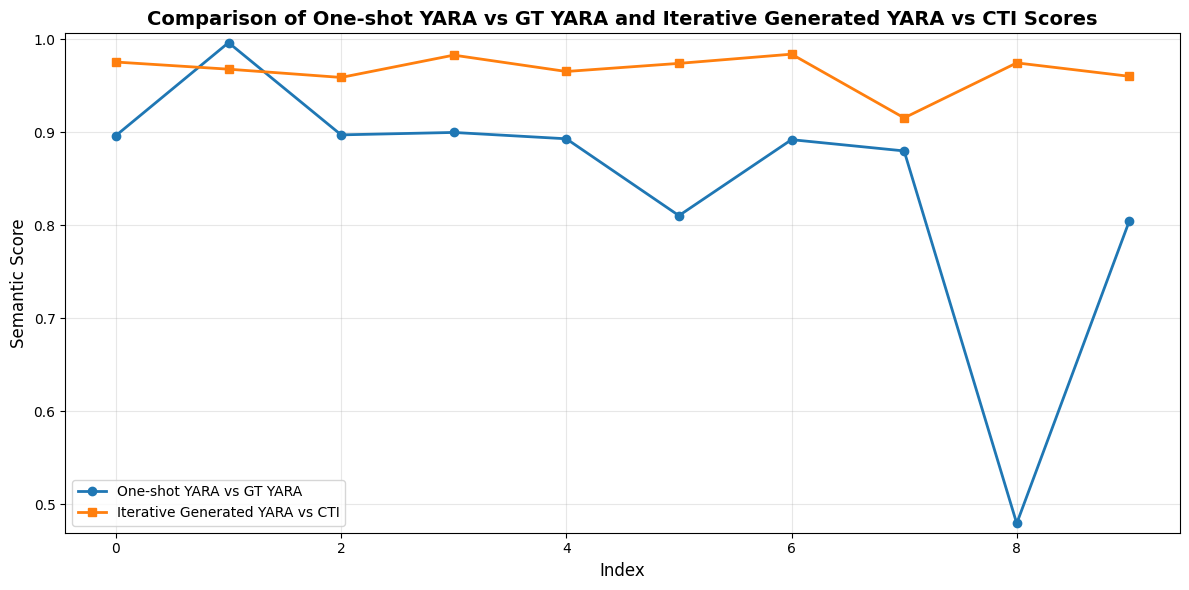

One-shot scores - Mean: 0.8451, Min: 0.4795, Max: 0.9965
Final scores - Mean: 0.9661, Min: 0.9156, Max: 0.9841


In [73]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both score lines
x_indices = range(len(one_shot_cti_rule_scores))
plt.plot(
    x_indices,
    one_shot_cti_rule_scores,
    marker="o",
    label="One-shot YARA vs GT YARA",
    linewidth=2,
    markersize=6,
)
plt.plot(
    x_indices,
    final_gen_cti_rule_scores,
    marker="s",
    label="Iterative Generated YARA vs CTI",
    linewidth=2,
    markersize=6,
)

# Set y-axis range based on min and max values
all_scores = one_shot_cti_rule_scores + final_gen_cti_rule_scores
y_min = min(all_scores) - 0.01
y_max = max(all_scores) + 0.01
plt.ylim(y_min, y_max)

# Labels and title
plt.xlabel("Index", fontsize=12)
plt.ylabel("Semantic Score", fontsize=12)
plt.title(
    "Comparison of One-shot YARA vs GT YARA and Iterative Generated YARA vs CTI Scores",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

# Print statistics
print(
    f"One-shot scores - Mean: {sum(one_shot_cti_rule_scores)/len(one_shot_cti_rule_scores):.4f}, Min: {min(one_shot_cti_rule_scores):.4f}, Max: {max(one_shot_cti_rule_scores):.4f}"
)
print(
    f"Final scores - Mean: {sum(final_gen_cti_rule_scores)/len(final_gen_cti_rule_scores):.4f}, Min: {min(final_gen_cti_rule_scores):.4f}, Max: {max(final_gen_cti_rule_scores):.4f}"
)

In [74]:
cti_vs_one_shot_rules = []
cti_vs_final_rules = []
gt_rule_vs_one_shot_rules = []
gt_rule_vs_final_rules = []
for cti, gt_rule, one_shot_rule, final_gen_rule in zip(
    iterative_refined_ctis,
    gt_rules,
    one_shot_rules,
    final_gen_rules,
):
    cti_vs_one_shot_rules.append(
        yara_semantic_evaluator(
            one_shot_rule,
            [cti],
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )
    cti_vs_final_rules.append(
        yara_semantic_evaluator(
            final_gen_rule,
            [cti],
            threshold=min_semantic_score_threshold,
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )
    gt_rule_vs_one_shot_rules.append(
        yara_semantic_evaluator(
            one_shot_rule,
            [gt_rule],
            threshold=min_semantic_score_threshold,
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )
    gt_rule_vs_final_rules.append(
        yara_semantic_evaluator(
            final_gen_rule,
            [gt_rule],
            threshold=min_semantic_score_threshold,
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )

In [ ]:
lengths = {
    "cti_vs_one_shot_rules": len(cti_vs_one_shot_rules),
    "cti_vs_final_rules": len(cti_vs_final_rules),
    "gt_rule_vs_one_shot_rules": len(gt_rule_vs_one_shot_rules),
    "gt_rule_vs_final_rules": len(gt_rule_vs_final_rules),
}

all_equal = len(set(lengths.values())) == 1

if all_equal:
    # Print True and the common length
    common_length = next(iter(set(lengths.values())))
    print(True, common_length)
else:
    # Print False and each length for debugging
    print(False)
    for name, ln in lengths.items():
        print(f"{name}: {ln}")

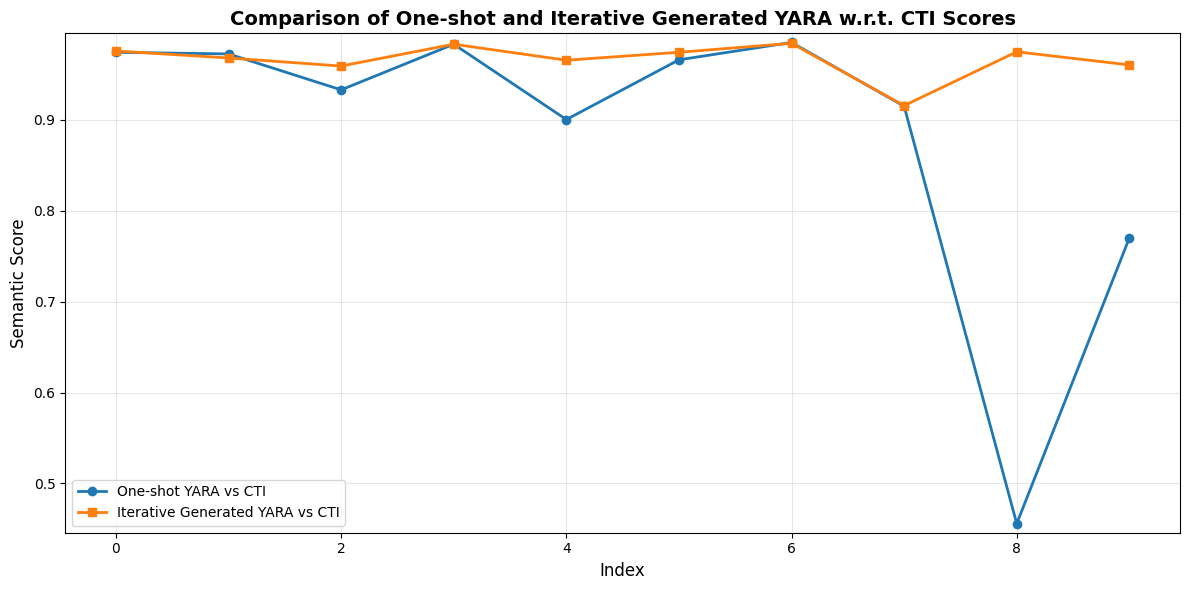

One-shot scores - Mean: 0.8855, Min: 0.4558, Max: 0.9851
Final scores - Mean: 0.9661, Min: 0.9156, Max: 0.9841


In [76]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both score lines
x_indices = range(len(cti_vs_one_shot_rules))
plt.plot(
    x_indices,
    cti_vs_one_shot_rules,
    marker="o",
    label="One-shot YARA vs CTI",
    linewidth=2,
    markersize=6,
)
plt.plot(
    x_indices,
    cti_vs_final_rules,
    marker="s",
    label="Iterative Generated YARA vs CTI",
    linewidth=2,
    markersize=6,
)

# Set y-axis range based on min and max values
all_scores = cti_vs_one_shot_rules + cti_vs_final_rules
y_min = min(all_scores) - 0.01
y_max = max(all_scores) + 0.01
plt.ylim(y_min, y_max)

# Labels and title
plt.xlabel("Index", fontsize=12)
plt.ylabel("Semantic Score", fontsize=12)
plt.title(
    "Comparison of One-shot and Iterative Generated YARA w.r.t. CTI Scores",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

# Print statistics
print(
    f"One-shot scores - Mean: {sum(cti_vs_one_shot_rules)/len(cti_vs_one_shot_rules):.4f}, Min: {min(cti_vs_one_shot_rules):.4f}, Max: {max(cti_vs_one_shot_rules):.4f}"
)
print(
    f"Final scores - Mean: {sum(cti_vs_final_rules)/len(cti_vs_final_rules):.4f}, Min: {min(cti_vs_final_rules):.4f}, Max: {max(cti_vs_final_rules):.4f}"
)

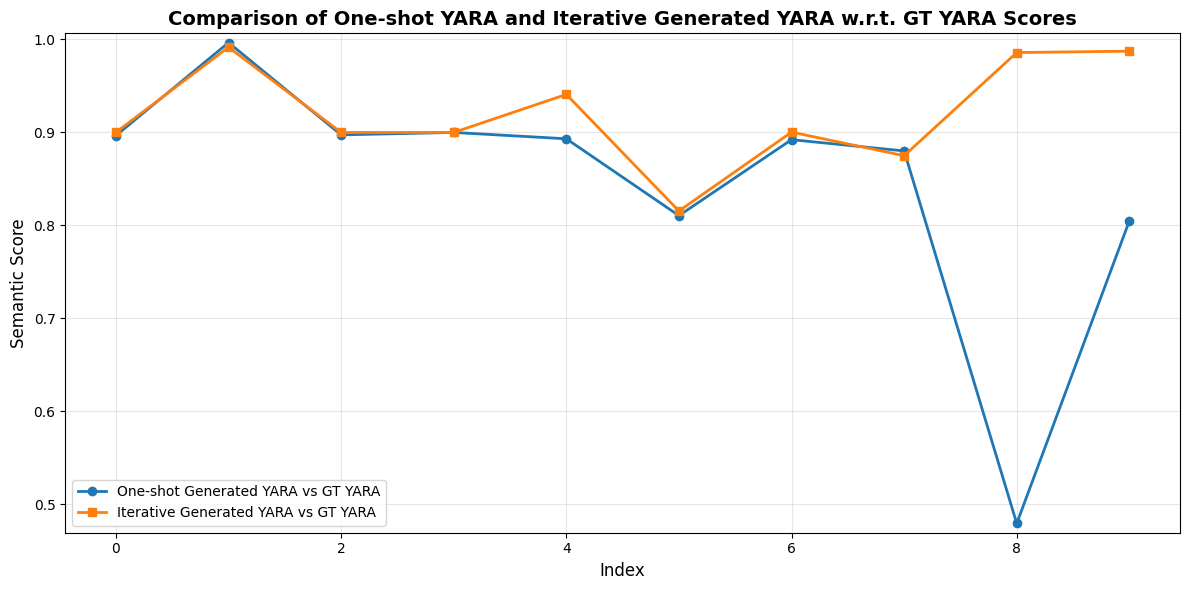

One-shot scores - Mean: 0.8451, Min: 0.4795, Max: 0.9965
Final scores - Mean: 0.9196, Min: 0.8155, Max: 0.9916


In [77]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both score lines
x_indices = range(len(gt_rule_vs_one_shot_rules))
plt.plot(
    x_indices,
    gt_rule_vs_one_shot_rules,
    marker="o",
    label="One-shot Generated YARA vs GT YARA",
    linewidth=2,
    markersize=6,
)
plt.plot(
    x_indices,
    gt_rule_vs_final_rules,
    marker="s",
    label="Iterative Generated YARA vs GT YARA",
    linewidth=2,
    markersize=6,
)

# Set y-axis range based on min and max values
all_scores = gt_rule_vs_one_shot_rules + gt_rule_vs_final_rules
y_min = min(all_scores) - 0.01
y_max = max(all_scores) + 0.01
plt.ylim(y_min, y_max)

# Labels and title
plt.xlabel("Index", fontsize=12)
plt.ylabel("Semantic Score", fontsize=12)
plt.title(
    "Comparison of One-shot YARA and Iterative Generated YARA w.r.t. GT YARA Scores",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

# Print statistics
print(
    f"One-shot scores - Mean: {sum(gt_rule_vs_one_shot_rules)/len(gt_rule_vs_one_shot_rules):.4f}, Min: {min(gt_rule_vs_one_shot_rules):.4f}, Max: {max(gt_rule_vs_one_shot_rules):.4f}"
)
print(
    f"Final scores - Mean: {sum(gt_rule_vs_final_rules)/len(gt_rule_vs_final_rules):.4f}, Min: {min(gt_rule_vs_final_rules):.4f}, Max: {max(gt_rule_vs_final_rules):.4f}"
)

# All Iterartive Samples

In [78]:
iterative_refined_ctis = []
gt_rules = []
one_shot_rules = []
one_shot_cti_rule_scores = []
final_gen_rules = []
final_gen_cti_rule_scores = []
for gen_rule in generated_rules:
    if (
        gen_rule["final_inference"]["no_of_retries"] > 0
        and gen_rule["final_inference"]["status"] == True
        # and gen_rule["one_shot_inference"]["feedback"]["semantic"][0]["scores"][0]
        # != gen_rule["final_inference"]["feedback"]["semantic"][-1]["scores"][0]
    ):
        iterative_refined_ctis.append(gen_rule["cti"])
        gt_rules.append(gen_rule["ground_truth_rule"])
        one_shot_rules.append(gen_rule["one_shot_inference"]["generated_rule"])
        one_shot_cti_rule_scores.append(
            gen_rule["one_shot_inference"]["feedback"]["semantic"][0]["scores"][0]
        )
        final_gen_rules.append(gen_rule["final_inference"]["generated_rule"])
        final_gen_cti_rule_scores.append(
            gen_rule["final_inference"]["feedback"]["semantic"][-1]["scores"][0]
        )

In [ ]:
lengths = {
    "iterative_refined_ctis": len(iterative_refined_ctis),
    "gt_rules": len(gt_rules),
    "one_shot_rules": len(one_shot_rules),
    "one_shot_cti_rule_scores": len(one_shot_cti_rule_scores),
    "final_gen_rules": len(final_gen_rules),
    "final_gen_cti_rule_scores": len(final_gen_cti_rule_scores),
}

all_equal = len(set(lengths.values())) == 1

if all_equal:
    # Print True and the common length
    common_length = next(iter(set(lengths.values())))
    print(True, common_length)
else:
    # Print False and each length for debugging
    print(False)
    for name, ln in lengths.items():
        print(f"{name}: {ln}")

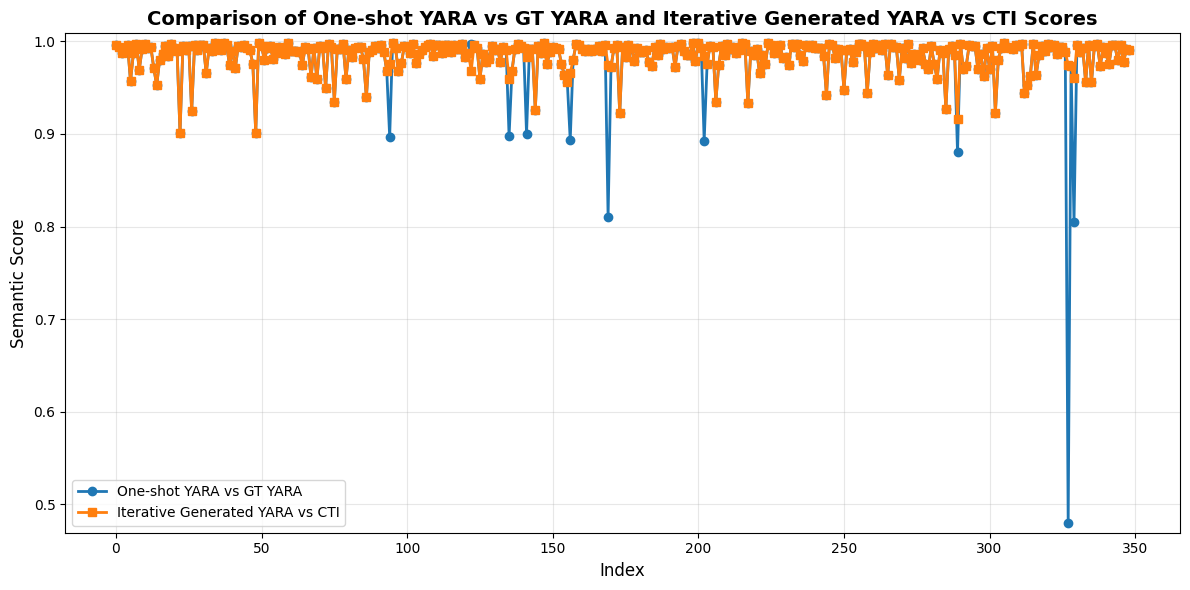

One-shot scores - Mean: 0.9812, Min: 0.4795, Max: 0.9985
Final scores - Mean: 0.9847, Min: 0.9007, Max: 0.9985


In [80]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both score lines
x_indices = range(len(one_shot_cti_rule_scores))
plt.plot(
    x_indices,
    one_shot_cti_rule_scores,
    marker="o",
    label="One-shot YARA vs GT YARA",
    linewidth=2,
    markersize=6,
)
plt.plot(
    x_indices,
    final_gen_cti_rule_scores,
    marker="s",
    label="Iterative Generated YARA vs CTI",
    linewidth=2,
    markersize=6,
)

# Set y-axis range based on min and max values
all_scores = one_shot_cti_rule_scores + final_gen_cti_rule_scores
y_min = min(all_scores) - 0.01
y_max = max(all_scores) + 0.01
plt.ylim(y_min, y_max)

# Labels and title
plt.xlabel("Index", fontsize=12)
plt.ylabel("Semantic Score", fontsize=12)
plt.title(
    "Comparison of One-shot YARA vs GT YARA and Iterative Generated YARA vs CTI Scores",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

# Print statistics
print(
    f"One-shot scores - Mean: {sum(one_shot_cti_rule_scores)/len(one_shot_cti_rule_scores):.4f}, Min: {min(one_shot_cti_rule_scores):.4f}, Max: {max(one_shot_cti_rule_scores):.4f}"
)
print(
    f"Final scores - Mean: {sum(final_gen_cti_rule_scores)/len(final_gen_cti_rule_scores):.4f}, Min: {min(final_gen_cti_rule_scores):.4f}, Max: {max(final_gen_cti_rule_scores):.4f}"
)

In [81]:
cti_vs_one_shot_rules = []
cti_vs_final_rules = []
gt_rule_vs_one_shot_rules = []
gt_rule_vs_final_rules = []
for cti, gt_rule, one_shot_rule, final_gen_rule in zip(
    iterative_refined_ctis,
    gt_rules,
    one_shot_rules,
    final_gen_rules,
):
    cti_vs_one_shot_rules.append(
        yara_semantic_evaluator(
            one_shot_rule,
            [cti],
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )
    cti_vs_final_rules.append(
        yara_semantic_evaluator(
            final_gen_rule,
            [cti],
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )
    gt_rule_vs_one_shot_rules.append(
        yara_semantic_evaluator(
            one_shot_rule,
            [gt_rule],
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )
    gt_rule_vs_final_rules.append(
        yara_semantic_evaluator(
            final_gen_rule,
            [gt_rule],
            model=cti_rule_semantic_model,
            tokenizer=cti_rule_semantic_tokenizer,
        )["scores"][0]
    )

In [ ]:
lengths = {
    "cti_vs_one_shot_rules": len(cti_vs_one_shot_rules),
    "cti_vs_final_rules": len(cti_vs_final_rules),
    "gt_rule_vs_one_shot_rules": len(gt_rule_vs_one_shot_rules),
    "gt_rule_vs_final_rules": len(gt_rule_vs_final_rules),
}

all_equal = len(set(lengths.values())) == 1

if all_equal:
    # Print True and the common length
    common_length = next(iter(set(lengths.values())))
    print(True, common_length)
else:
    # Print False and each length for debugging
    print(False)
    for name, ln in lengths.items():
        print(f"{name}: {ln}")

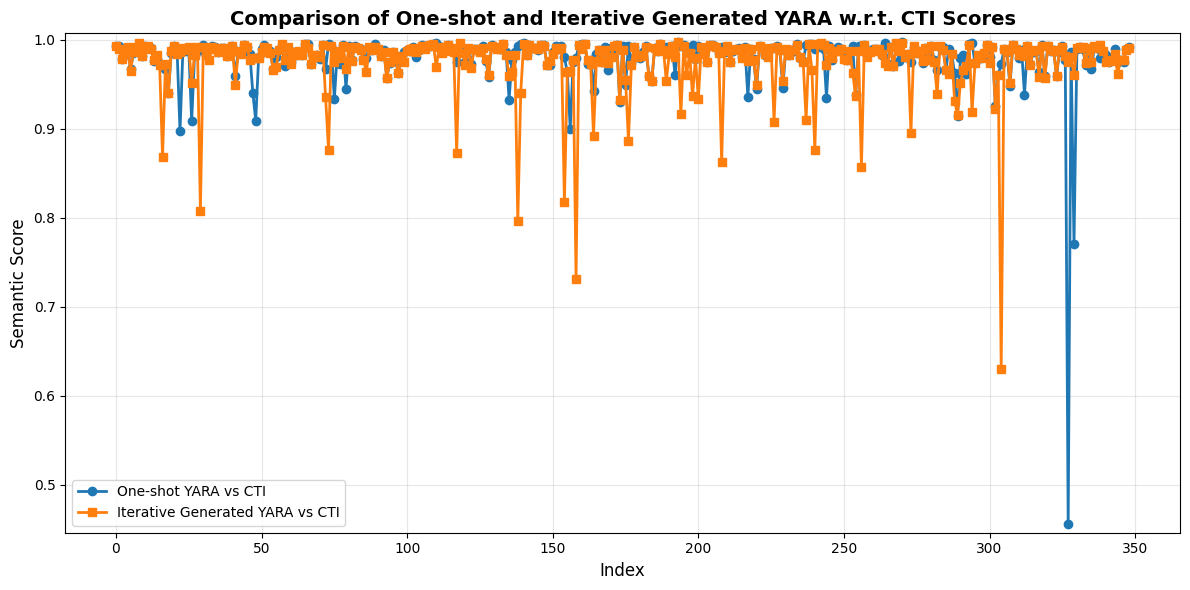

One-shot scores - Mean: 0.9802, Min: 0.4558, Max: 0.9974
Final scores - Mean: 0.9751, Min: 0.6300, Max: 0.9973


In [83]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both score lines
x_indices = range(len(cti_vs_one_shot_rules))
plt.plot(
    x_indices,
    cti_vs_one_shot_rules,
    marker="o",
    label="One-shot YARA vs CTI",
    linewidth=2,
    markersize=6,
)
plt.plot(
    x_indices,
    cti_vs_final_rules,
    marker="s",
    label="Iterative Generated YARA vs CTI",
    linewidth=2,
    markersize=6,
)

# Set y-axis range based on min and max values
all_scores = cti_vs_one_shot_rules + cti_vs_final_rules
y_min = min(all_scores) - 0.01
y_max = max(all_scores) + 0.01
plt.ylim(y_min, y_max)

# Labels and title
plt.xlabel("Index", fontsize=12)
plt.ylabel("Semantic Score", fontsize=12)
plt.title(
    "Comparison of One-shot and Iterative Generated YARA w.r.t. CTI Scores",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

# Print statistics
print(
    f"One-shot scores - Mean: {sum(cti_vs_one_shot_rules)/len(cti_vs_one_shot_rules):.4f}, Min: {min(cti_vs_one_shot_rules):.4f}, Max: {max(cti_vs_one_shot_rules):.4f}"
)
print(
    f"Final scores - Mean: {sum(cti_vs_final_rules)/len(cti_vs_final_rules):.4f}, Min: {min(cti_vs_final_rules):.4f}, Max: {max(cti_vs_final_rules):.4f}"
)

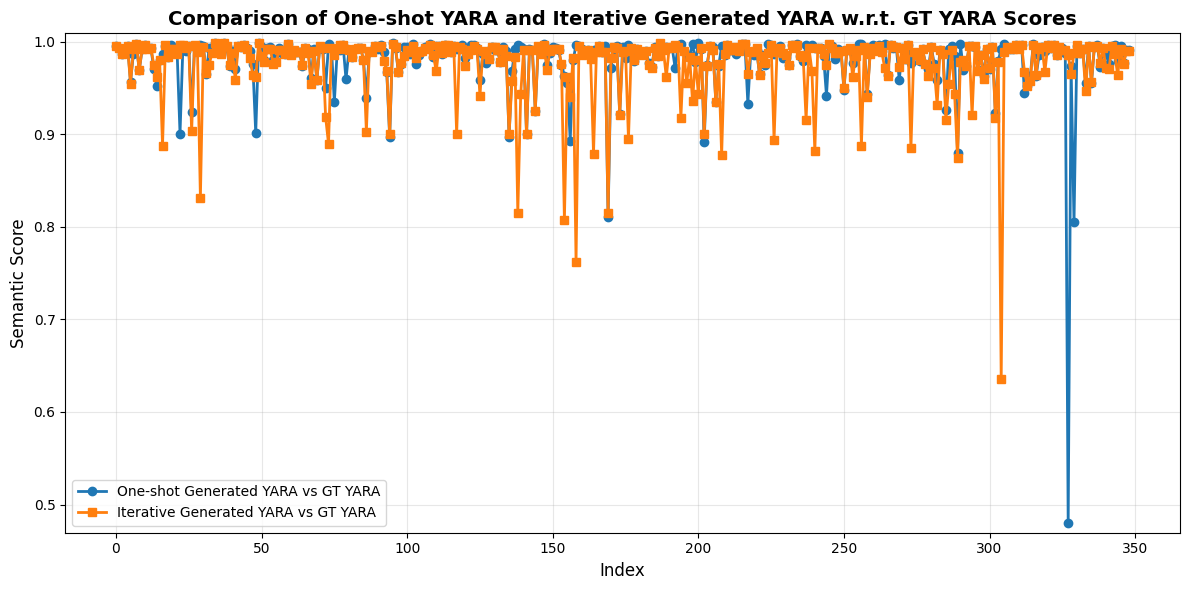

One-shot scores - Mean: 0.9812, Min: 0.4795, Max: 0.9985
Final scores - Mean: 0.9753, Min: 0.6355, Max: 0.9991


In [84]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both score lines
x_indices = range(len(gt_rule_vs_one_shot_rules))
plt.plot(
    x_indices,
    gt_rule_vs_one_shot_rules,
    marker="o",
    label="One-shot Generated YARA vs GT YARA",
    linewidth=2,
    markersize=6,
)
plt.plot(
    x_indices,
    gt_rule_vs_final_rules,
    marker="s",
    label="Iterative Generated YARA vs GT YARA",
    linewidth=2,
    markersize=6,
)

# Set y-axis range based on min and max values
all_scores = gt_rule_vs_one_shot_rules + gt_rule_vs_final_rules
y_min = min(all_scores) - 0.01
y_max = max(all_scores) + 0.01
plt.ylim(y_min, y_max)

# Labels and title
plt.xlabel("Index", fontsize=12)
plt.ylabel("Semantic Score", fontsize=12)
plt.title(
    "Comparison of One-shot YARA and Iterative Generated YARA w.r.t. GT YARA Scores",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

# Print statistics
print(
    f"One-shot scores - Mean: {sum(gt_rule_vs_one_shot_rules)/len(gt_rule_vs_one_shot_rules):.4f}, Min: {min(gt_rule_vs_one_shot_rules):.4f}, Max: {max(gt_rule_vs_one_shot_rules):.4f}"
)
print(
    f"Final scores - Mean: {sum(gt_rule_vs_final_rules)/len(gt_rule_vs_final_rules):.4f}, Min: {min(gt_rule_vs_final_rules):.4f}, Max: {max(gt_rule_vs_final_rules):.4f}"
)